In [ ]:
# Import the 'os' module to interact with the operating system.
# We'll use it to set an environment variable for controlling TensorFlow's logging.
import os

# Set the TensorFlow logging level to '3' to suppress informational messages.
# This helps keep our notebook output clean by filtering out INFO, WARNING, and most ERROR messages.
# - '0' (default): Shows all messages.
# - '1': Filters out INFO messages.
# - '2': Filters out INFO and WARNING messages.
# - '3': Filters out INFO, WARNING, and ERROR messages.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import the core TensorFlow library, our main tool for building the model.
import tensorflow as tf

# Configure GPU memory management. This is a crucial step for preventing errors.
# The loop iterates through all physical GPUs available to TensorFlow.
for gpu in tf.config.list_physical_devices('GPU'):
    # By default, TensorFlow allocates all available GPU memory at once.
    # Setting memory growth to `True` changes this behavior to allocate memory
    # on an as-needed basis. This is much more memory-efficient and helps
    # prevent "Out of Memory" (OOM) errors.
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
'''
This code implements a diffusion model to generate images of automobiles using the CIFAR-10 dataset.
The main objective is to demonstrate a simplified version of a diffusion model that can gradually denoise
random noise into meaningful images through an iterative process.

CIFAR-10 contains 50,000 training images and 10,000 test images, with each image being a 32x32 pixel RGB color image.
For this implementation, only the automobile class images are extracted from the training set. The images are preprocessed
by normalizing the pixel values to the range [-1, 1] by dividing by 127.5 and subtracting 1.0.
'''

In [ ]:
# Load the CIFAR-10 dataset using TensorFlow's built-in Keras utility.
# This function returns two tuples: one for training data (images and labels)
# and one for testing data.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# --- Filter for a Single Class (Automobiles) ---
# The CIFAR-10 dataset has 10 classes, with 'automobile' being labeled as '1'.
# We want to train our model *only* on these images.
# 1. y_train.squeeze(): The original labels have a shape of (50000, 1).
#    squeeze() removes the unnecessary dimension, making it (50000,).
# 2. y_train.squeeze() == 1: This creates a boolean mask (an array of True/False values).
#    It will be 'True' for every label that is '1' and 'False' otherwise.
# 3. X_train[...]: We use this mask to select only the images from X_train
#    where the corresponding label is '1'.

X_train = X_train[y_train.squeeze() == 1]

# --- Normalize the Image Data ---
# Neural networks train best when input data is scaled to a small, consistent range.
# The original pixel values are integers from 0 to 255.
# We normalize them to be floating-point numbers in the range [-1.0, 1.0].
# This is a common practice for models that use activations like tanh.
# Math:
# - A pixel value of 0 becomes (0 / 127.5) - 1.0 = -1.0
# - A pixel value of 127.5 becomes (127.5 / 127.5) - 1.0 = 0.0
# - A pixel value of 255 becomes (255 / 127.5) - 1.0 = 1.0

X_train = (X_train / 127.5) - 1.0

In [ ]:
# Import the NumPy library for numerical operations, specifically for creating our time schedule.
import numpy as np

# --- Basic Training Parameters ---

# IMG_SIZE: The height and width of our input images.
# CIFAR-10 images are 32x32 pixels, so we set this to 32.
IMG_SIZE = 32

# BATCH_SIZE: The number of images to process in a single training step.
# A larger batch size can lead to more stable training but requires more memory.
# 128 is a common choice for this type of problem.
BATCH_SIZE = 128

# --- Diffusion-Specific Parameters ---

# timesteps: This is the total number of discrete steps in our diffusion process.
# In the "forward process," we will gradually add noise to an image over these 16 steps.
# In the "reverse process," our model will learn to denoise the image in 16 steps.
# A larger number of timesteps creates a more gradual (and easier to learn) (generally used in 1000 range)
# transition, but is computationally more expensive.
timesteps = 16

# time_bar: This defines the "noise schedule." It's an array that dictates
# how much of the original image ("signal") is left at each timestep.
# 1. np.linspace(0, 1.0, timesteps + 1): Creates an array of 17 evenly spaced
#    values from 0.0 to 1.0. Think of this as the "cumulative noise ratio."
# 2. 1 - ...: We subtract from 1 to get the "signal rate."
#
# The result is an array `time_bar` where:
# - time_bar[0] = 1.0 (at step 0, we have 100% original image)
# - time_bar[16] = 0.0 (at the final step, we have 0% original image, i.e., pure noise)
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

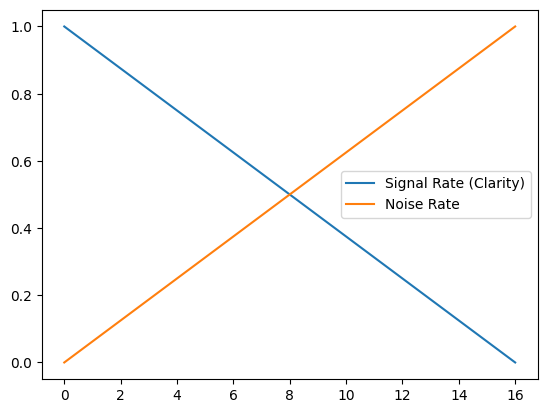

In [ ]:
# Import the pyplot module from matplotlib for plotting.
import matplotlib.pyplot as plt

# --- Plotting the Signal and Noise Rates ---

# - 'time_bar' represents the amount of the original image signal, or its "clarity."
# - '1 - time_bar' represents the amount of noise.
# We'll plot them as they are and clarify in the interpretation below.

# Plot the 'time_bar' array. This curve shows the proportion of the original image
# signal remaining at each timestep. It starts at 1.0 (all signal) and ends at 0.0 (no signal).
plt.plot(time_bar, label='Signal Rate (Clarity)')

# Plot '1 - time_bar'. This is the inverse, showing the proportion of noise
# at each timestep. It starts at 0.0 (no noise) and ends at 1.0 (all noise).
plt.plot(1 - time_bar, label='Noise Rate')

# Add a legend to the plot to identify the lines.
plt.legend()

# Display the plot.
plt.show()

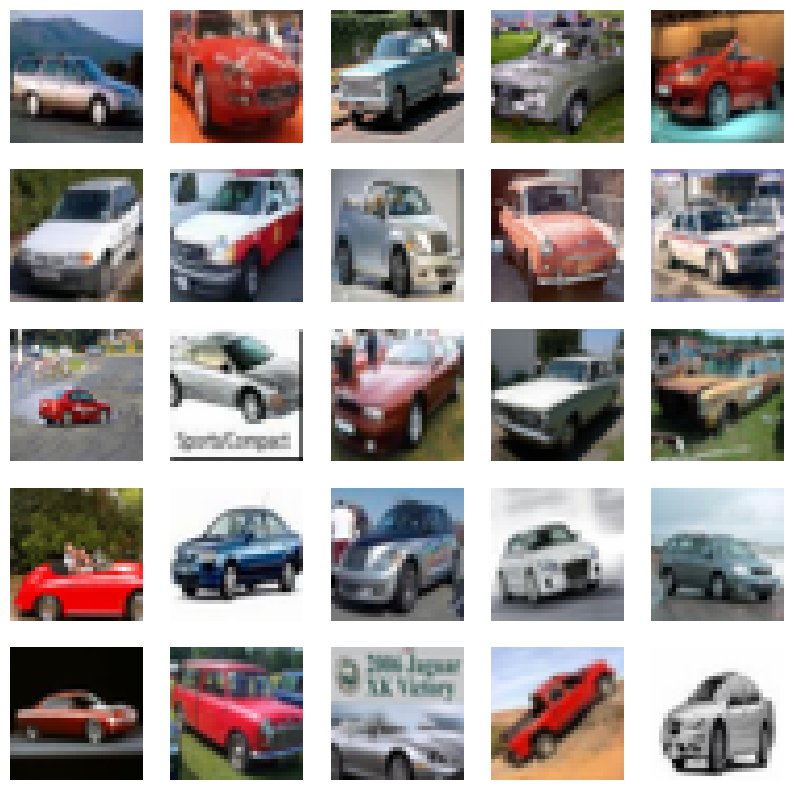

In [ ]:
def cvtImg(img):
    """
    Converts an image from the model's [-1, 1] range to a displayable [0, 1] range.

    This function performs min-max normalization to rescale the pixel values.

    Args:
        img (np.array): A single image with pixel values in the [-1, 1] range.

    Returns:
        np.array: The same image with pixel values rescaled to the [0, 1] range.
    """
    # Step 1: Shift the entire range of pixel values so that the minimum value becomes 0.
    img = img - img.min()

    # Step 2: Scale the values. The new maximum value (original max - original min) is
    # divided by itself, scaling it to 1. All other values are scaled proportionally.
    # We add a small epsilon (1e-7) to prevent division by zero if the image is all one color.
    img = img / (img.max() + 1e-7)

    # Step 3: Ensure the data type is a 32-bit float, which is standard for display.
    return img.astype(np.float32)


def show_examples(x):
    """
    Displays a 5x5 grid of images from a given batch.

    Args:
        x (np.array): A batch of images.
    """
    # Create a new figure for our plot with a size of 10x10 inches.
    plt.figure(figsize=(10, 10))

    # We want to display the first 25 images in a 5x5 grid.
    for i in range(25):
        # Create a subplot within the 5x5 grid at the (i+1)-th position.
        plt.subplot(5, 5, i + 1)

        # Get the i-th image from the batch.
        img = x[i]

        # Use our helper function to convert the image from [-1, 1] to the [0, 1] range
        # so it can be displayed correctly.
        img = cvtImg(img)

        # Display the processed image.
        plt.imshow(img)

        # Turn off the axis ticks and labels for a cleaner look.
        plt.axis('off')

    # Show the entire grid of images.
    plt.show()


# --- Verify Data Loading ---
# Call the function with our training data to display 25 example images.
# This is a quick sanity check to ensure we have loaded and filtered the
# car images correctly before we start training the model.
show_examples(X_train)


In [ ]:
def forward_noise(x, t):
    """
    Applies noise to a batch of images for given timesteps, based on a predefined schedule.

    This function simulates one step of the forward diffusion process, generating two versions
    of a noisy image: one for timestep 't' and a slightly noisier one for 't+1'.

    Args:
        x (tf.Tensor): The batch of original, clean images, scaled to [-1, 1].
        t (np.array): A batch of integer timesteps.

    Returns:
        tuple: A tuple containing:
            - img_a (tf.Tensor): The noisy image at timestep 't'. This will be our target.
            - img_b (tf.Tensor): The noisy image at timestep 't+1'. This will be our model's input.
    """
    # --- Fetch Signal Rates from the Schedule ---
    # 'time_bar' holds the "signal rate" (how much of the original image is preserved).
    # It decreases from 1.0 to 0.0 as the timestep increases.
    # So, 'a' will have a higher signal rate (less noise) than 'b'.
    a = time_bar[t]
    b = time_bar[t + 1]

    # --- Generate Noise ---
    # Create a random noise tensor from a standard normal distribution (mean=0, std=1).
    # It has the same shape as our input image batch. It's crucial to use the SAME
    # noise vector to generate both img_a and img_b for a consistent transition.
    noise = np.random.normal(size=x.shape)

    # --- Reshape Rates for Broadcasting ---
    # The signal rates 'a' and 'b' are currently 1D arrays. We need to reshape them
    # to (batch_size, 1, 1, 1) so they can be correctly multiplied with the
    # image batch, which has a shape of (batch_size, height, width, channels).
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))

    # --- Create the Noisy Images via Linear Interpolation ---
    # The noisy image is a mix of the original image 'x' and the random 'noise'.
    # The amount of each is determined by the signal rate.
    # Formula: new_image = x * signal_rate + noise * noise_rate
    # Since noise_rate = 1 - signal_rate, we get the following:

    # img_a: The less noisy image (our target)
    img_a = x * a + noise * (1 - a)
    # img_b: The more noisy image (our input)
    img_b = x * b + noise * (1 - b)

    return img_a, img_b


[ 1  0 14  1  3  1  9 13 15 15  1  0 12  6  3  3  7  4 14  3  3  8  9  4
 15]
Examples of images after applying random noise:


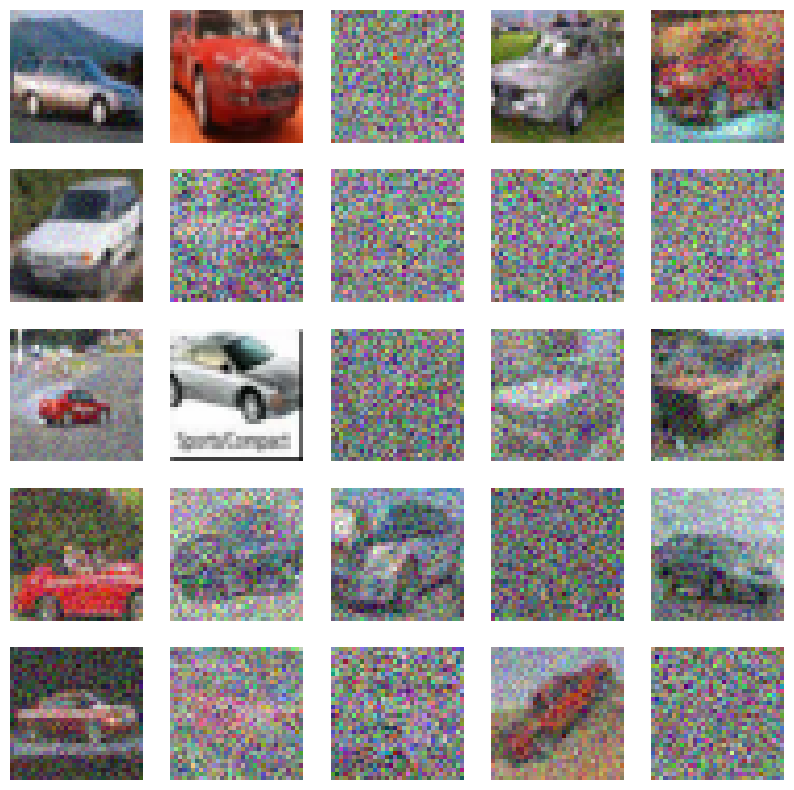

In [ ]:


def generate_ts(num):
    """
    Generates a specified number of random timesteps for training.

    During training, we want the model to learn to denoise from any random
    noise level, not just in a sequential order. This function helps create
    the random timesteps needed for each image in a batch.

    Args:
        num (int): The number of random timesteps to generate (e.g., the batch size).

    Returns:
        np.array: An array of random integers between 0 and (timesteps-1).
    """
    return np.random.randint(0, timesteps, size=num)


# --- Step 1: Generate random timesteps ---
# We'll test on 25 images, so we need 25 corresponding random timesteps.
# Each image will be noised to a different level.
t = generate_ts(25)
print(t)
# --- Step 2: Apply the forward noise process ---
# We take the first 25 images from our training set and the 25 random timesteps.
# The `forward_noise` function will return two batches of images:
# 'a': images noised to timestep 't'
# 'b': images noised to timestep 't+1'
a, b = forward_noise(X_train[:25], t)

# --- Step 3: Visualize the results ---
# We display the images from batch 'a'.
# This shows us what our clean images look like after applying a random
# amount of noise, as defined by the timesteps in 't'.
print("Examples of images after applying random noise:")
show_examples(a)

In [ ]:
'''
The key idea is to use the timestep information to scale or modulate the image features.
This allows the network to change its behavior based on how much noise is in the image,
which is critical for the denoising process.


The U-Net Building Block: A Time-Conditioned Residual Block

At the heart of our diffusion model is a U-Net architecture. Unlike a standard U-Net used for segmentation,
ours needs to be time-conditioned. This means it must take both the noisy image and the current timestep t
as input.

This is achieved with a special type of residual block that processes image and time information in separate
pathways before cleverly combining them.

Block Architecture Explained:

    Image Pathway: This is a standard convolutional path that extracts spatial features (edges, textures, shapes)
    from the input image (x_img).

    Timestep Pathway: The timestep number t is first converted into a dense vector embedding (we'll see this
    in the full U-Net model). This embedding is then processed through its own small neural network to produce
    a "modulation" vector.

    Feature Modulation: The magic happens here. The modulation vector from the timestep pathway is multiplied
    element-wise with the feature map from the image pathway. This allows the network to decide which
    features are important based on the current noise level. For example, at high noise levels (t is large), it might learn to amplify large, structural features, whereas at low noise levels (t is small),
    it might focus on refining fine details.

    Residual Connection: Finally, the modulated features are added back to another convolutional branch
    of the original input. This skip connection, a hallmark of residual networks (ResNets), helps
    with gradient flow and allows the model to learn more effectively.

    Uses layer normalization for stable training

 '''

In [ ]:

def block(x_img, x_ts):
    """
    A time-conditioned residual block for the U-Net.

    This block processes an image tensor and a timestep embedding, using the
    timestep to modulate the image features.

    Args:
        x_img (tf.Tensor): The input image feature map.
                           Shape: (batch, height, width, channels)
        x_ts (tf.Tensor): The processed timestep embedding.
                          Shape: (batch, embedding_dim)

    Returns:
        tf.Tensor: The output feature map after time-conditioned processing.
    """

    # --- Timestep Pathway (Modulation Parameters) ---
    # This branch processes the time embedding to create a modulation vector.
    # 1. Apply a Dense (fully-connected) layer to the time embedding.
    time_parameter = layers.Dense(128)(x_ts)
    # 2. Apply a ReLU activation for non-linearity.
    time_parameter = layers.Activation('relu')(time_parameter)
    # 3. Reshape the vector from (batch, 128) to (batch, 1, 1, 128).
    # This makes it broadcastable with the image feature map for multiplication.
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)


    # --- Image Pathway ---
    # This branch processes the image features.
    # 1. A 3x3 convolution extracts spatial features from the input image.
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    # 2. Apply a ReLU activation.
    x_parameter = layers.Activation('relu')(x_parameter)


    # --- Feature Modulation ---
    # Multiply the image features by the time-derived modulation vector.
    # This scales the feature activations based on the current timestep.
    x_parameter = x_parameter * time_parameter


    # --- Main Processing & Residual Connection ---
    # 1. Process the original input image through another 3x3 convolution.
    # This forms the main path of the residual block.
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)

    # 2. Add the time-modulated features to the main path.
    # This is the residual connection that combines spatial and temporal info.
    x_out = x_out + x_parameter

    # 3. Apply Layer Normalization. This stabilizes training by normalizing
    # the activations across the feature channels for each item in the batch.
    x_out = layers.LayerNormalization()(x_out)

    # 4. Final ReLU activation on the combined features.
    x_out = layers.Activation('relu')(x_out)

    return x_out



In [ ]:
'''
This is the most complex part of the project, as it brings together the custom block we just defined into a
full U-Net architecture.

Building the Time-Conditioned U-Net Model

This is where we define the core architecture of our denoising model. We use a U-Net, a type of convolutional
neural network known for its "U" shape. It consists of:

    An Encoder (Downsampling Path): This part of the network progressively downsamples the image, capturing
    contextual features at different scales.

    A Bottleneck: The lowest resolution point of the U-Net, where the most compressed feature representation
    is processed.

    A Decoder (Upsampling Path): This part progressively upsamples the feature map back to the original
      image size. It uses information from the encoder via skip connections to reconstruct the image with
      high fidelity

Crucially, our U-Net is time-conditioned. At every level, we feed in the timestep information, allowing
the network to adjust its denoising strategy based on the noise level.
'''


In [ ]:
def make_model():
    """
    Constructs and returns the time-conditioned U-Net model.
    """
    # === 1. INPUT LAYERS ===
    # We have two separate inputs for our model.
    # Input for the noisy image: A 32x32 RGB image.
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    # Input for the timestep: A single integer 't'.
    x_ts = x_ts_input = layers.Input(shape=(1,), dtype=tf.int64, name='x_ts_input')

    # --- Timestep Embedding ---
    # A single number 't' isn't very useful for a neural network. We convert it
    # into a high-dimensional vector (an embedding) using a small Multi-Layer Perceptron (MLP).
    # This allows the model to learn a rich representation for each timestep.
    x_ts = layers.Dense(192)(tf.cast(x_ts, tf.float32))
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)


    # === 2. ENCODER PATH (DOWNSAMPLING) ===
    # The encoder shrinks the image, forcing the network to learn compressed features.

    # -- Level 1 (32x32) --
    # Process the input with our time-conditioned block.
    x = x32 = block(x, x_ts)
    # Downsample to 16x16. We save the output of the block (x32) for a skip connection later.
    x = layers.MaxPool2D(2)(x)

    # -- Level 2 (16x16) --
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x) # Downsample to 8x8

    # -- Level 3 (8x8) --
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x) # Downsample to 4x4

    # -- Level 4 (4x4, becomes the bottleneck input) --
    x = x4 = block(x, x_ts)


    # === 3. BOTTLENECK ===
    # At the lowest resolution, we further process the features.
    x = layers.Flatten()(x)
    # We concatenate the time embedding again here to reinforce the time-conditioning.
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    # Reshape the features back into a spatial format to begin the decoder path.
    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)


    # === 4. DECODER PATH (UPSAMPLING) ===
    # The decoder reconstructs the image, using skip connections to preserve details.

    # -- Level 4 (Upsample from 4x4 to 8x8) --
    # The skip connection is the key: we concatenate the output from the corresponding
    # encoder level (x4) with our current feature map.
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x) # Upsample to 8x8

    # -- Level 3 (Upsample from 8x8 to 16x16) --
    x = layers.Concatenate()([x, x8]) # Skip connection from level 3
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x) # Upsample to 16x16

    # -- Level 2 (Upsample from 16x16 to 32x32) --
    x = layers.Concatenate()([x, x16]) # Skip connection from level 2
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x) # Upsample to 32x32

    # -- Level 1 (Final processing at 32x32) --
    x = layers.Concatenate()([x, x32]) # Skip connection from level 1
    x = block(x, x_ts)


    # === 5. OUTPUT LAYER ===
    # A final 1x1 convolution maps the high-dimensional feature map (128 channels)
    # back down to our desired 3-channel RGB image. The output values are unbounded.
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)

    # Create the Keras Model, defining the two inputs and the final output.
    model = tf.keras.models.Model([x_input, x_ts_input], x, name="time_conditioned_unet")
    return model

# Instantiate the model.
model = make_model()

# Print a summary of the model's architecture, including the layers and number of parameters.
model.summary()

Model: "time_conditioned_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_ts_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 1)            0           ['x_ts_input[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 192)          384         ['tf.cast[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 192)         384         ['dense[0][0]']                  
 alization)                                                                   

In [ ]:

'''
Input Layer
[Image Input 32x32x3]     [Timestep Input (1,)]
       |                         |
       |                    Dense (192)
       |                         |
       |                  LayerNormalization
       |                         |
       |                     ReLU
       |                         |
       \_________________________|
                    |
                    v
=== Encoder Path (Downsampling) ===
Level 1 (32x32)
[Time-conditioned Block] -----> (skip connection x32)
        |
    MaxPool2D
        |
Level 2 (16x16)
[Time-conditioned Block] -----> (skip connection x16)
        |
    MaxPool2D
        |
Level 3 (8x8)
[Time-conditioned Block] -----> (skip connection x8)
        |
    MaxPool2D
        |
Level 4 (4x4)
[Time-conditioned Block] -----> (skip connection x4)
        |
        v
=== Bottleneck ===
    Flatten
        |
    Concatenate
        |
    Dense (128)
        |
  LayerNormalization
        |
      ReLU
        |
  Dense (4x4x32)
        |
  LayerNormalization
        |
      ReLU
        |
    Reshape
        |
        v
=== Decoder Path (Upsampling) ===
Level 4 (4x4)
    Concatenate <----- (skip connection x4)
        |
[Time-conditioned Block]
        |
    UpSampling2D
        |
Level 3 (8x8)
    Concatenate <----- (skip connection x8)
        |
[Time-conditioned Block]
        |
    UpSampling2D
        |
Level 2 (16x16)
    Concatenate <----- (skip connection x16)
        |
[Time-conditioned Block]
        |
    UpSampling2D
        |
Level 1 (32x32)
    Concatenate <----- (skip connection x32)
        |
[Time-conditioned Block]
        |
        v
=== Output Layer ===
Conv2D (3 channels, 1x1)
        |
    Output (32x32x3)


'''

In [ ]:
'''
loss function measures how wrong the model's predictions are.
optimizer updates the model's internal parameters to reduce the loss.

Mean Absolute Error (MAE): Compared to Mean Squared Error (MSE), MAE is sometimes considered less
sensitive to outliers, which can lead to more stable training for image generation tasks.
It directly penalizes the difference between the predicted and target pixels, encouraging
the model to generate visually similar images.

'''


# --- 1. The Optimizer ---
# We choose the Adam optimizer, which is a very popular and effective algorithm
# for deep learning. It adapts the learning rate for each parameter,
# often leading to faster convergence.
# The 'learning_rate' is a crucial hyperparameter that controls the step size
# of the updates. A value of 0.0008 is a good starting point.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)

# --- 2. The Loss Function ---
# We use Mean Absolute Error (MAE), also known as L1 Loss.
# For our task, the model outputs a predicted "less noisy" image.
# MAE calculates the average absolute difference between each pixel of the
# predicted image and the target image. It's a straightforward and robust
# choice for image-to-image tasks like this.
# Loss = average(|pixel_target - pixel_predicted|)
loss_func = tf.keras.losses.MeanAbsoluteError()

# --- 3. Compiling the Model ---
# The .compile() method brings everything together. It configures the model
# with the chosen optimizer and loss function, preparing it for training.
model.compile(loss=loss_func, optimizer=optimizer)

In [ ]:
'''
Generating Images: The Reverse Process (Inference)

Now that we have a model, we can use it to generate new images of cars.
This is done through the reverse process. The logic is the inverse of the forward process we defined earlier:

    Start with Pure Noise: We begin by generating an image that is pure, random Gaussian noise.
    This corresponds to the state of an image at the highest timestep (t = timesteps - 1).

    Iteratively Denoise: We then loop backward through all the timesteps, from the noisiest (t=15) d
    own to the cleanest (t=0).

    Apply the Model: In each step, we feed the current noisy image and its corresponding timestep t into
    our trained U-Net. The model's job is to predict a slightly cleaner version of the image
    (the image as it would have looked at step t-1).

    Repeat: The output of one step becomes the input for the next, progressively removing noise until
    we are left with a clear, coherent image at t=0.


 '''

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]



Final Generated Images:


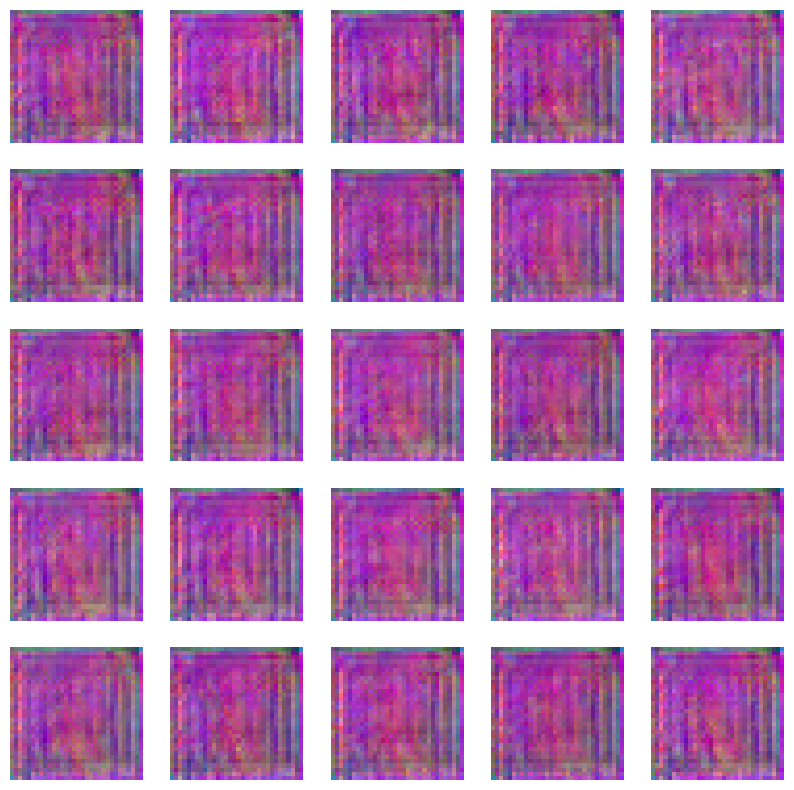

In [ ]:
# Import trange from the tqdm library for a progress bar during generation.
# This helps us visually track the denoising process.
from tqdm import trange

def predict():
    """
    Generates images from random noise using the trained diffusion model.

    This function implements the reverse diffusion process, starting with pure
    noise and iteratively applying the model to denoise it step-by-step.
    """
    # --- Step 1: Initialize with pure random noise ---
    # Create a batch of 32 images, where each image is filled with random
    # values from a standard normal distribution. This is our starting point,
    # representing images at the highest noise level.
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))

    # --- Step 2: Iteratively denoise through all timesteps ---
    # CRITICAL: We must loop BACKWARDS, from the highest timestep (most noise)
    # to the lowest (least noise).
    # reversed(range(timesteps)) will iterate t = 15, 14, 13, ..., 0.
    for i in trange(timesteps):
        t = timesteps - 1 - i # t goes from 15 down to 0

        # At each step, we ask the model to predict the slightly cleaner version
        # of the image 'x' given that it's at noise level 't'.
        x = model.predict(
            [x, np.full(32, t)], # The model takes two inputs: the image batch and the corresponding timesteps
            verbose=0
        )

    # --- Step 3: Display the final generated images ---
    # After the loop completes (at t=0), 'x' should contain a batch of
    # recognizable car images. We use our helper function to display them.

    print("\nFinal Generated Images:")
    show_examples(x)

# Call the function to generate and display a new batch of images.
predict()

In [ ]:
'''
Visualizing the Generation Process, Step by Step

While the predict function shows us the final result, this predict_step function lets us peek
inside the reverse diffusion process itself. It captures and displays the state of an image at
various stages as it is being denoised, giving us a "film strip" view of generation.

This function will:

    Start with a batch of pure noise.

    Iteratively apply the trained model, looping backward from the highest timestep (t=15) to the lowest (t=0).

    Store a snapshot of the image at regular intervals during this process.

    Display the snapshots in a row to visualize the transformation from noise to a car.


'''

Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.56it/s]



Denoising sequence (from t=15 down to t=0):


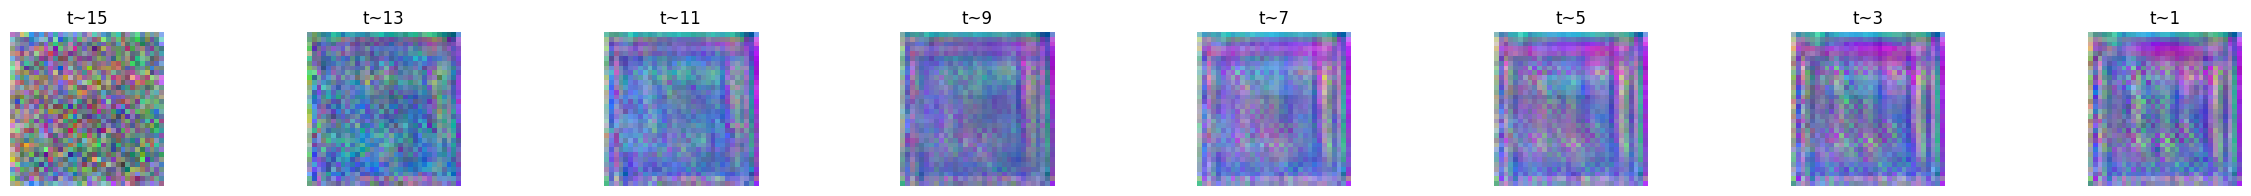


Final generated images from this run:


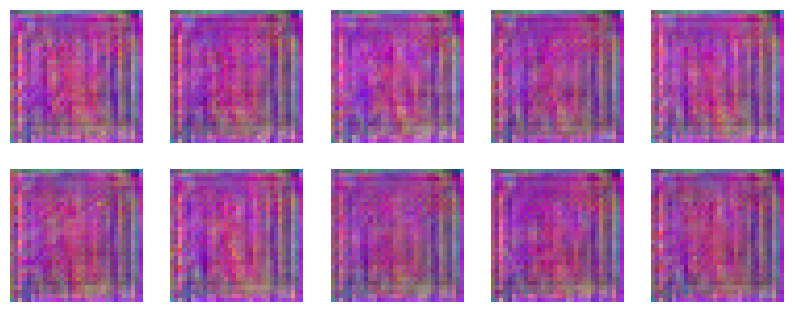

In [ ]:
def show_examples(x):
    """
    Displays a grid of images from a given batch.
    """
    # Determine the number of images in the batch.
    num_examples = len(x)

    # Create a figure for the plot.
    plt.figure(figsize=(10, 10))

    # Loop through the number of available images (up to 25).
    # The min() function here prevents the IndexError.
    for i in range(min(num_examples, 25)):
        plt.subplot(5, 5, i + 1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

def predict_step():
    """
    Visualizes the step-by-step denoising process of the diffusion model,
    showing how an image evolves from noise.
    """
    xs = []
    x = np.random.normal(size=(10, IMG_SIZE, IMG_SIZE, 3))

    print("Visualizing the reverse diffusion process...")
    for i in trange(timesteps):
        t = timesteps - 1 - i # Loop backwards from t=15 down to 0
        x = model.predict([x, np.full(10, t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    # --- Create the "Film Strip" Visualization ---
    plt.figure(figsize=(30, 2))
    print("\nDenoising sequence (from t=15 down to t=0):")
    for i in range(len(xs)):
        actual_t = timesteps - 1 - (i * 2)
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f't~{actual_t}')
        plt.axis('off')
    plt.show()

    # --- Display the Final Generated Images ---
    print("\nFinal generated images from this run:")
    # This call is now safe because show_examples() is fixed.
    show_examples(x)

# Run the visualization.
predict_step()

In [ ]:
'''
Defining a Single Training Step

This function encapsulates the entire process for training our model on a single batch of images.
Executing this function once constitutes one "step" of training.

Here's the logic:

    Get a batch of clean images.

    Create a noisy pair: For each clean image, we use our forward_noise function to generate
    a pair of images: a more noisy version (x_b at timestep t+1) and
    a slightly less noisy version (x_a at timestep t).

    Train the model: We feed the more noisy image (x_b) and its timestep t into the model.
    We then tell the model that its prediction should have been the less noisy image (x_a).

    Calculate Loss & Update: The model compares its prediction to the target (x_a),
    calculates the loss (MAE), and the optimizer updates the model's weights to reduce this
    loss for the next time.
'''

In [ ]:
def train_one(x_img):
    """
    Performs a single training step for the diffusion model.

    The model is given a noisy image from timestep 't+1' and trained
    to predict the slightly less noisy image from timestep 't'.

    Args:
        x_img (np.array): A batch of clean input images from the training dataset.

    Returns:
        float: The training loss for this batch.
    """
    # --- Step 1: Generate random timesteps ---
    # We need a random timestep for each image in the batch.
    x_ts = generate_ts(len(x_img))

    # --- Step 2: Create the noisy input/target pair ---
    # 'x_a' is the image at step t (less noisy)
    # 'x_b' is the image at step t+1 (more noisy)
    x_a, x_b = forward_noise(x_img, x_ts)

    # --- Step 3: Train the model on the reverse task ---
    #  - Input to model: The MORE noisy image (x_b) and its timestep (x_ts).
    #  - Target for model: The LESS noisy image (x_a).
    # This teaches the model to perform the denoising step from t+1 -> t.
    #
    # This has been swapped to correctly train the reverse process.
    loss = model.train_on_batch([x_b, x_ts], x_a)

    return loss

In [ ]:
'''
The Main Training Loop

This is the final and most important step. The train function orchestrates the entire training process.
It runs for a specified number of epochs (full passes or rounds over the data). In each epoch,
it repeatedly performs the following actions:

    Selects a random batch of clean car images from our dataset.

    Calls our train_one() function to perform a single training step on that batch.

    Calculates the loss and updates the model's weights to get better at denoising.

    Updates a progress bar to give us real-time feedback on the training progress and current loss.
'''


In [ ]:

def train(epochs=50):
    """
    The main training loop for the diffusion model.

    Args:
        epochs (int): The total number of epochs (training rounds) to run.
    """
    # Use trange from the tqdm library to create a smart progress bar for the outer loop.
    # This bar will track our progress through the epochs.
    bar = trange(epochs)

    # In this setup, one "epoch" is defined as processing 100 batches.
    # This provides frequent feedback without needing to iterate over the entire dataset.
    batches_per_epoch = 100

    # The outer loop iterates through the total number of epochs.
    for i in bar:
        # The inner loop iterates through the batches within a single epoch.
        for j in range(batches_per_epoch):
            # --- Step 1: Sample a Random Batch ---
            # Generate BATCH_SIZE random integers between 0 and the total number of images.
            random_indices = np.random.randint(0, len(X_train), size=BATCH_SIZE)
            # Use these indices to select a random batch of images from our training data.
            x_img = X_train[random_indices]

            # --- Step 2: Perform a Single Training Step ---
            # Call our previously defined function to train the model on this batch.
            # This performs the forward noise, prediction, loss calculation, and weight update.
            loss = train_one(x_img)

            # --- Step 3: Update Progress Bar ---
            # Update the description on the tqdm progress bar to show the current loss.
            # This gives us a live view of how well the model is learning.
            bar.set_description(f"loss: {loss:.5f}")

# --- Start Training! ---
# Calling this function will kick off the entire training process.
# This will take some time depending on your hardware.



In [ ]:
'''
Orchestrating the Full Training Process

This final cell is the master script that manages the entire end-to-end training workflow.
Instead of just training once, it runs a series of training sessions.
After each session, it adjusts the learning rate and visualizes the model's progress.
This iterative approach is a powerful way to achieve better results.

The process for each of the 10 master rounds is:

    Train: Call the train() function to train the model for 50 full epochs.

    Adjust Learning Rate: Decrease the learning rate slightly. This technique, called learning rate decay,
    helps the model fine-tune its weights and converge to a better solution. Early in training,
    a higher learning rate helps make big progress; later, a smaller learning rate allows for more precise,
    smaller adjustments.

    Visualize: Call predict() and predict_step() to generate new images. This provides immediate visual
    feedback, allowing us to see how the model's image generation capabilities improve after each round of training.

 '''


--- Starting Master Round 1/10 ---


loss: 0.02503: 100%|██████████| 50/50 [07:34<00:00,  9.09s/it]



Learning rate updated to: 0.000720
Generating sample images...


100%|██████████| 16/16 [00:01<00:00, 12.95it/s]



Final Generated Images:


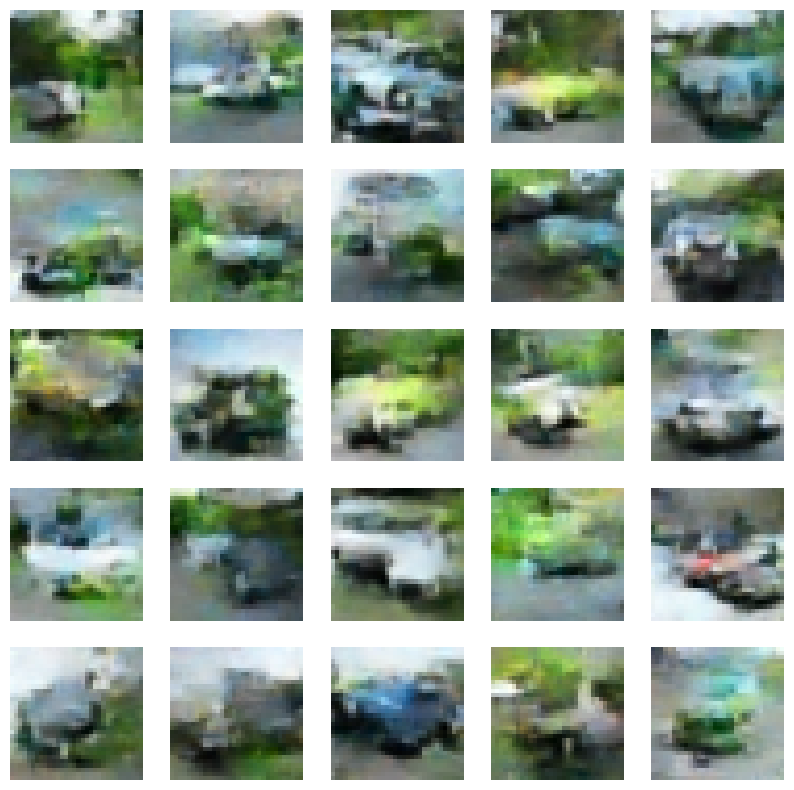

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:01<00:00, 11.98it/s]



Denoising sequence (from t=15 down to t=0):


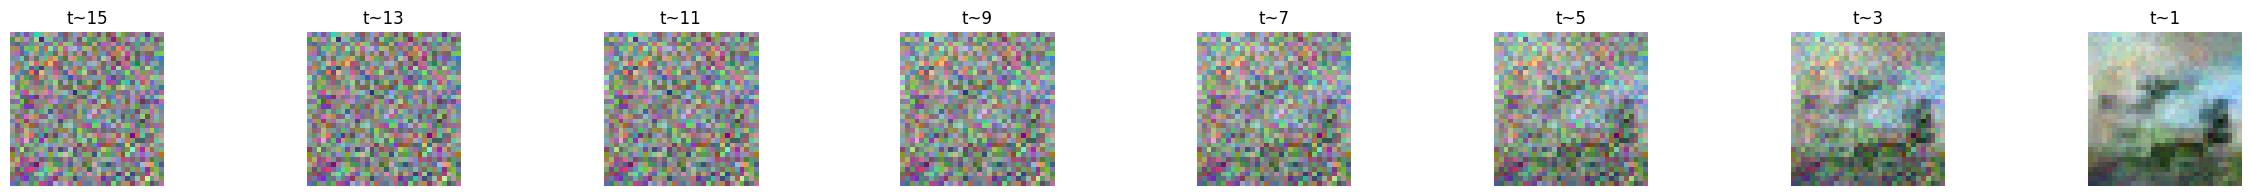


Final generated images from this run:


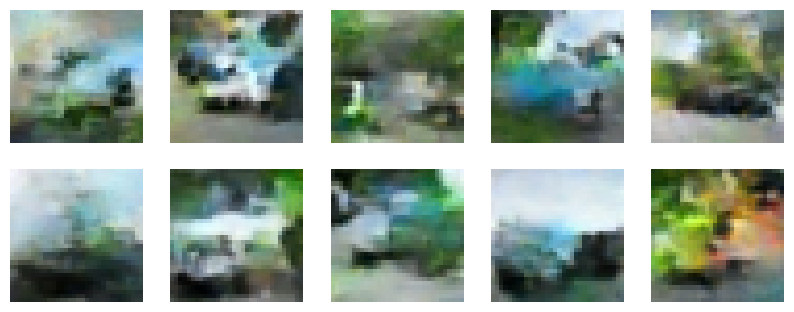


--- Starting Master Round 2/10 ---


loss: 0.02301: 100%|██████████| 50/50 [07:32<00:00,  9.05s/it]



Learning rate updated to: 0.000648
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.90it/s]



Final Generated Images:


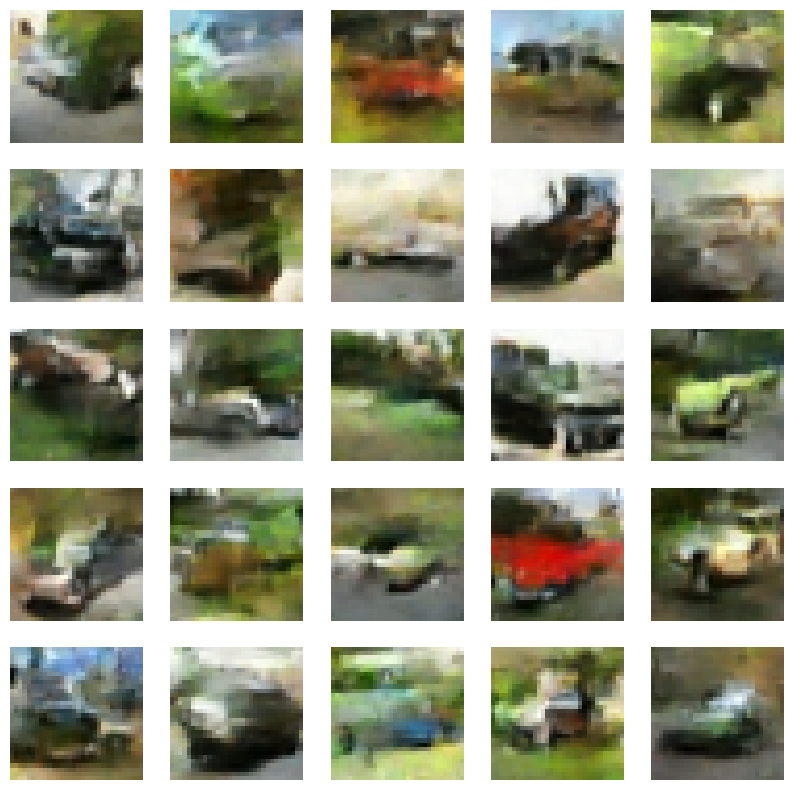

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.63it/s]



Denoising sequence (from t=15 down to t=0):


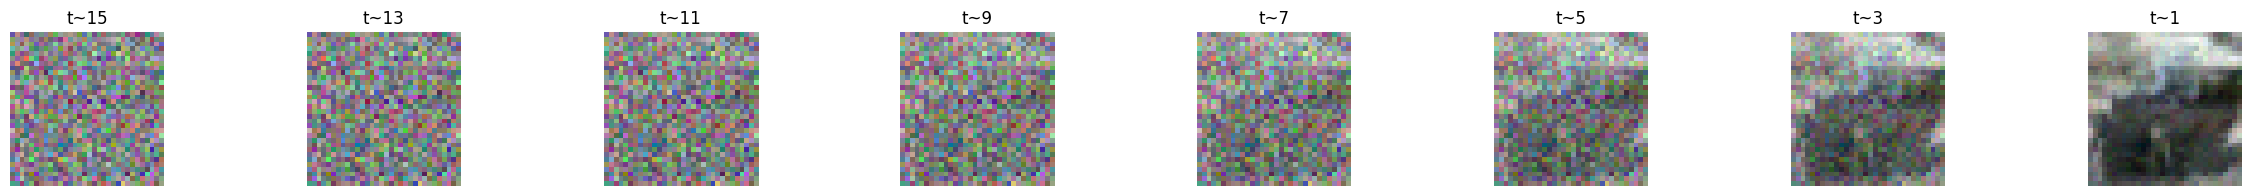


Final generated images from this run:


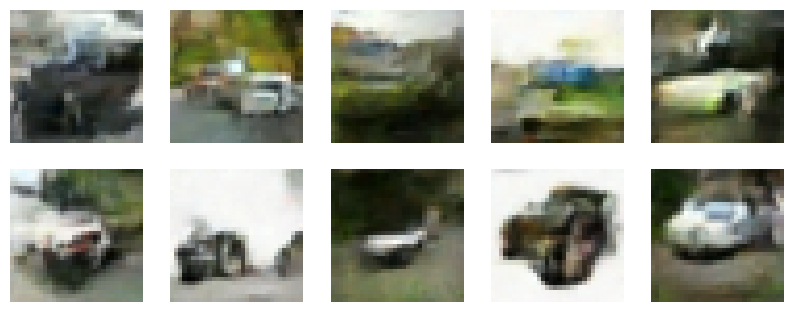


--- Starting Master Round 3/10 ---


loss: 0.02196: 100%|██████████| 50/50 [07:27<00:00,  8.95s/it]



Learning rate updated to: 0.000583
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.80it/s]



Final Generated Images:


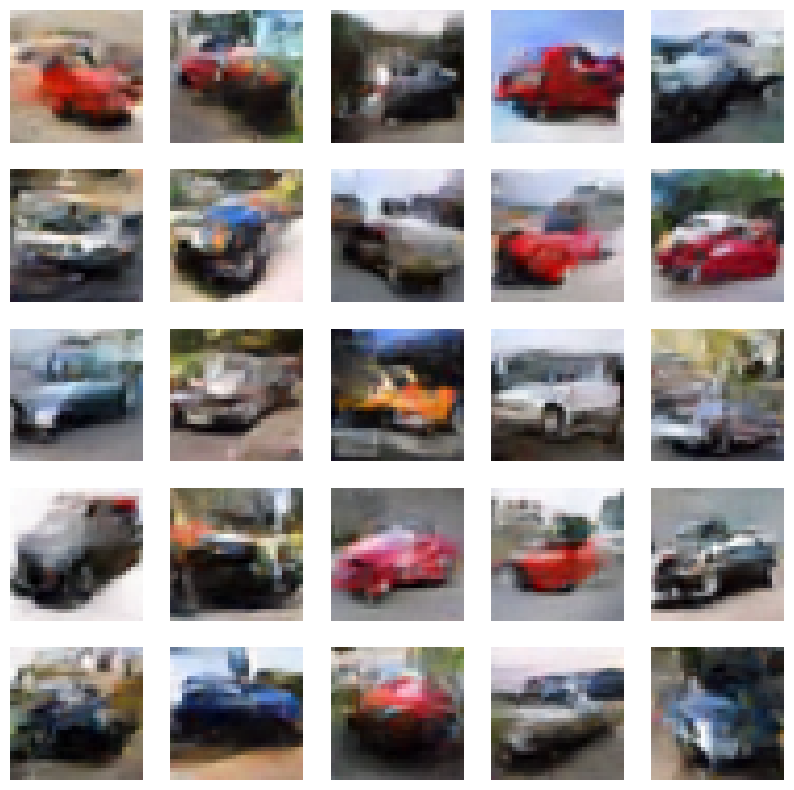

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.41it/s]



Denoising sequence (from t=15 down to t=0):


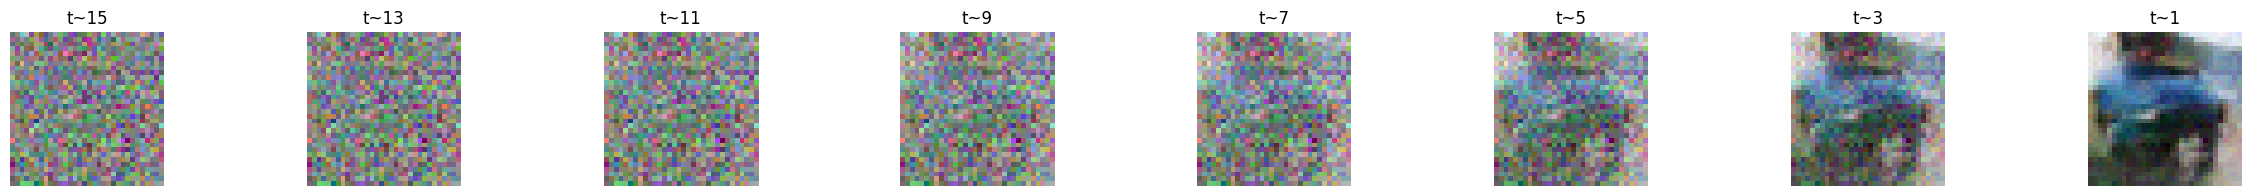


Final generated images from this run:


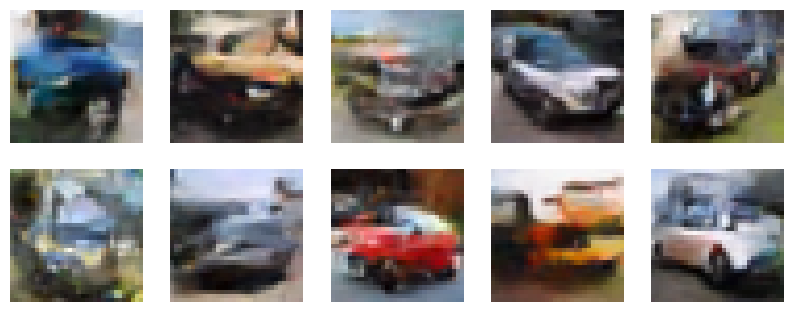


--- Starting Master Round 4/10 ---


loss: 0.02148: 100%|██████████| 50/50 [07:18<00:00,  8.77s/it]



Learning rate updated to: 0.000525
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.61it/s]



Final Generated Images:


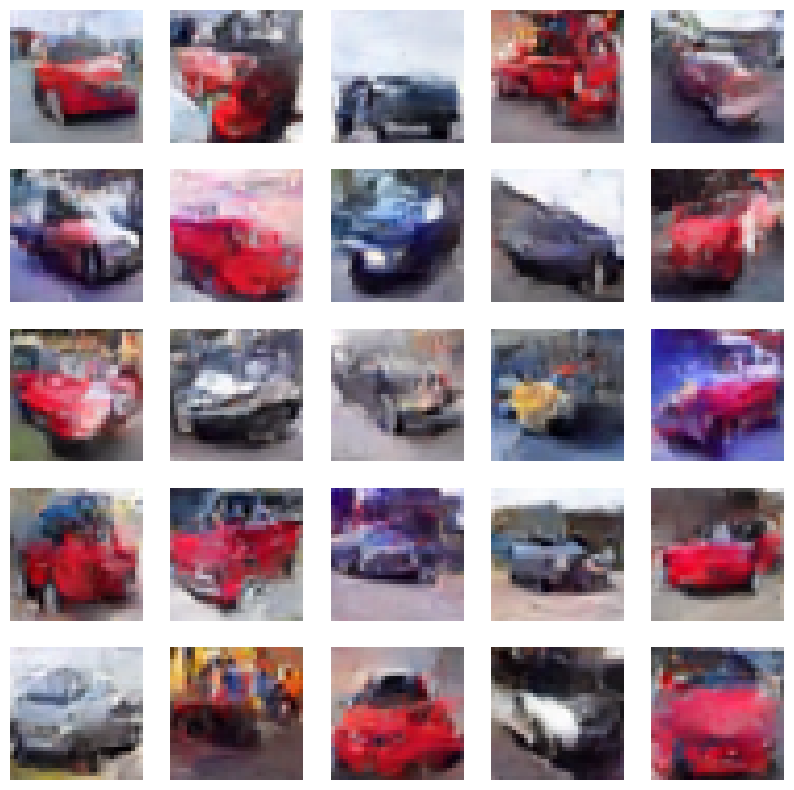

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.70it/s]



Denoising sequence (from t=15 down to t=0):


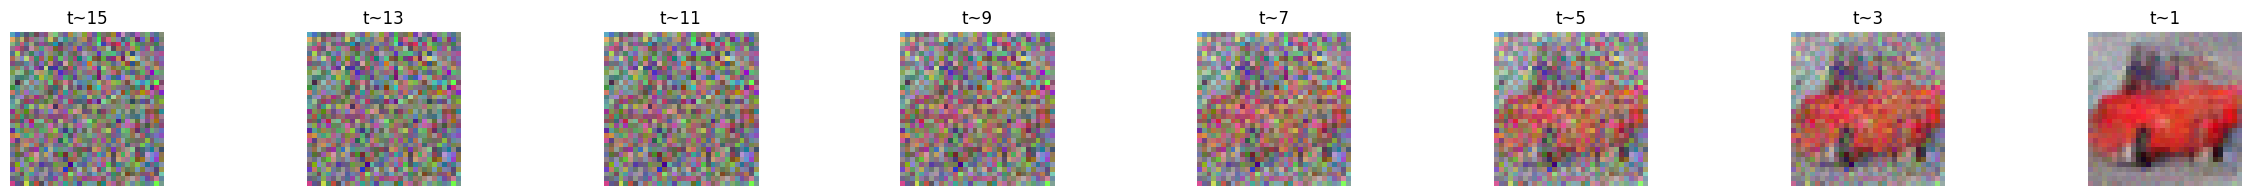


Final generated images from this run:


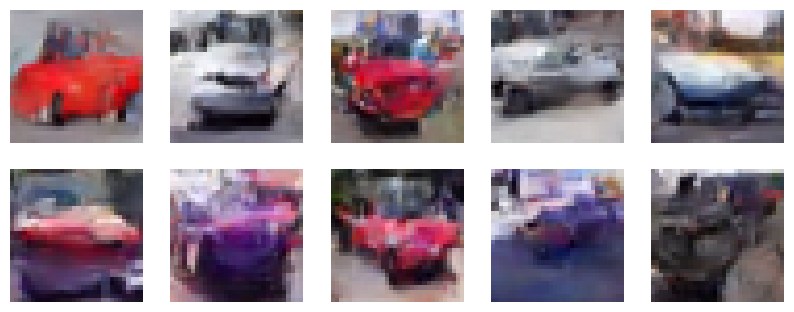


--- Starting Master Round 5/10 ---


loss: 0.02190: 100%|██████████| 50/50 [07:18<00:00,  8.76s/it]



Learning rate updated to: 0.000472
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.43it/s]



Final Generated Images:


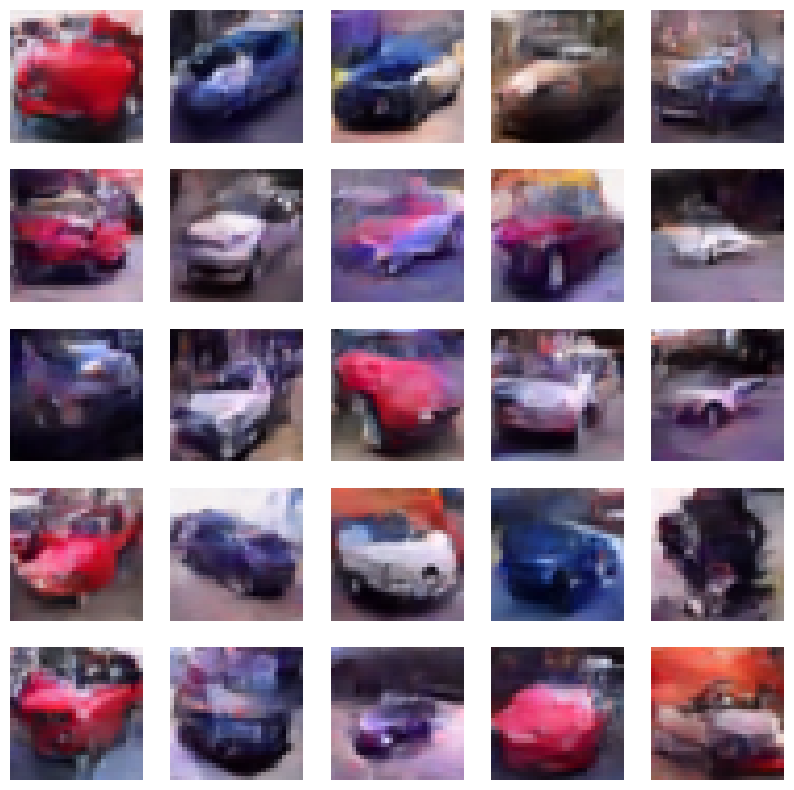

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.39it/s]



Denoising sequence (from t=15 down to t=0):


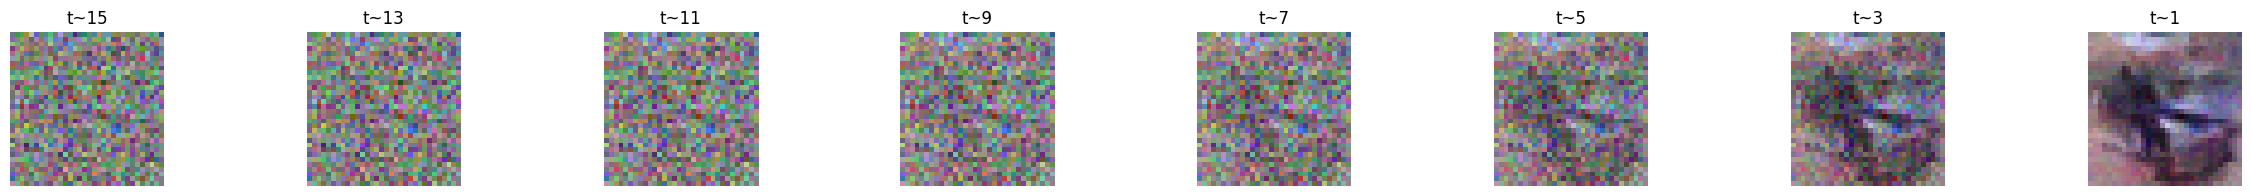


Final generated images from this run:


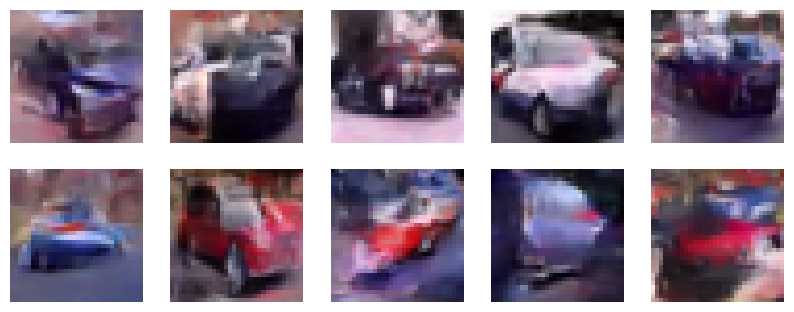


--- Starting Master Round 6/10 ---


loss: 0.02101: 100%|██████████| 50/50 [07:32<00:00,  9.05s/it]



Learning rate updated to: 0.000425
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 19.92it/s]



Final Generated Images:


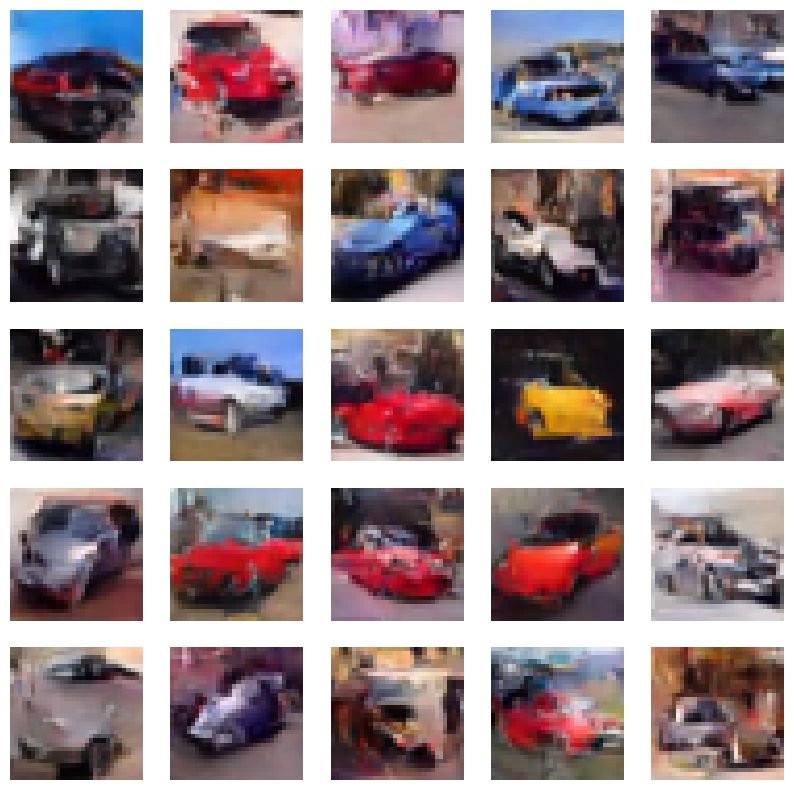

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.08it/s]



Denoising sequence (from t=15 down to t=0):


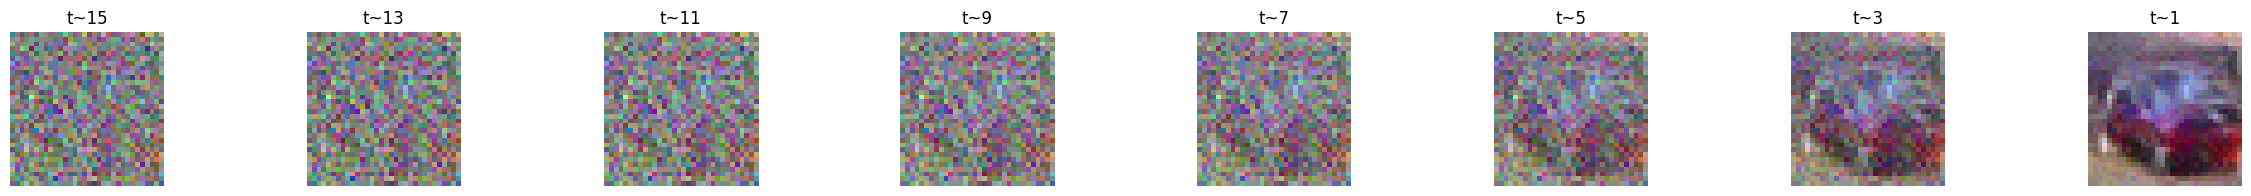


Final generated images from this run:


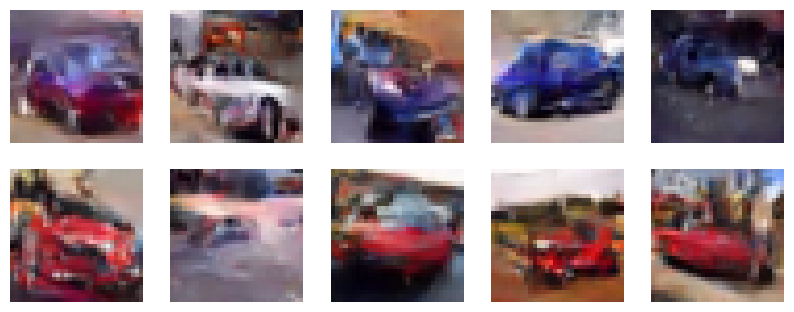


--- Starting Master Round 7/10 ---


loss: 0.02111: 100%|██████████| 50/50 [07:33<00:00,  9.06s/it]



Learning rate updated to: 0.000383
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.31it/s]



Final Generated Images:


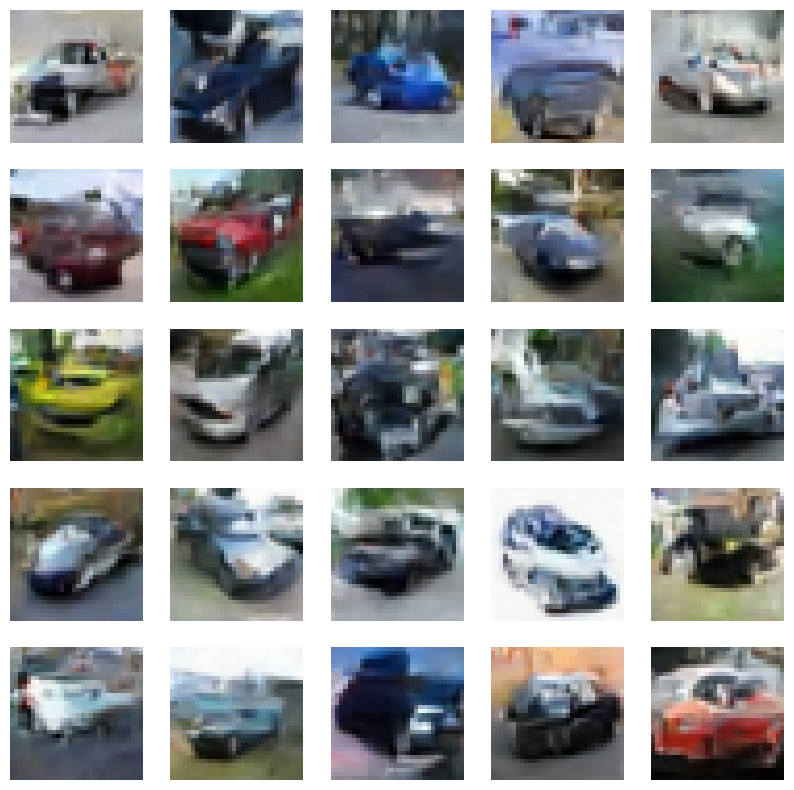

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.69it/s]



Denoising sequence (from t=15 down to t=0):


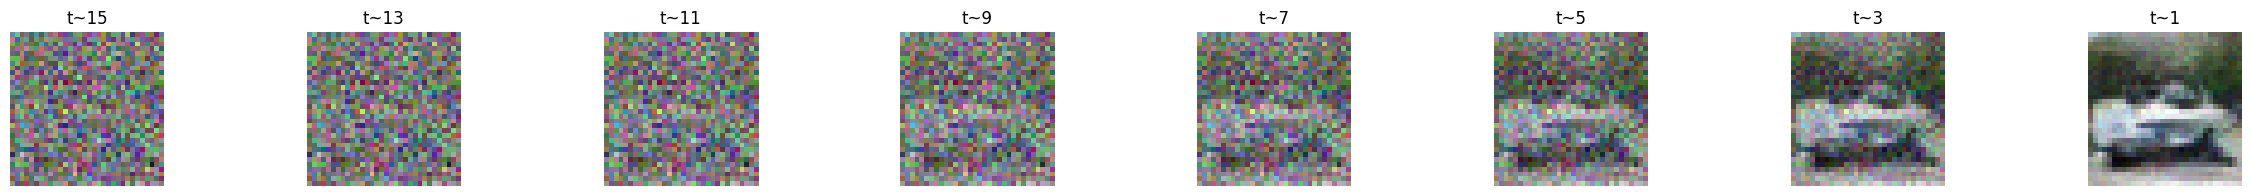


Final generated images from this run:


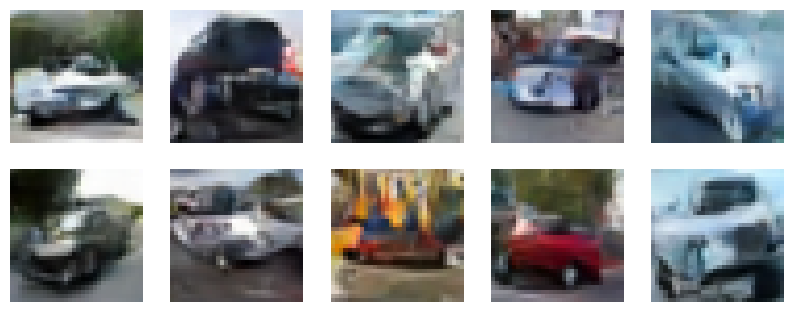


--- Starting Master Round 8/10 ---


loss: 0.02019: 100%|██████████| 50/50 [07:35<00:00,  9.11s/it]



Learning rate updated to: 0.000344
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.20it/s]



Final Generated Images:


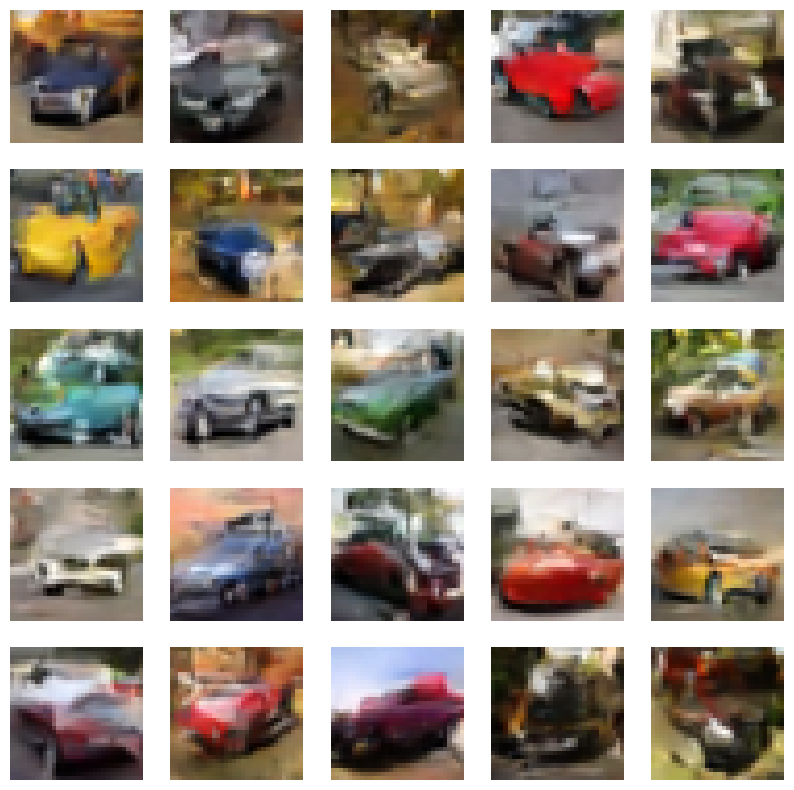

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.87it/s]



Denoising sequence (from t=15 down to t=0):


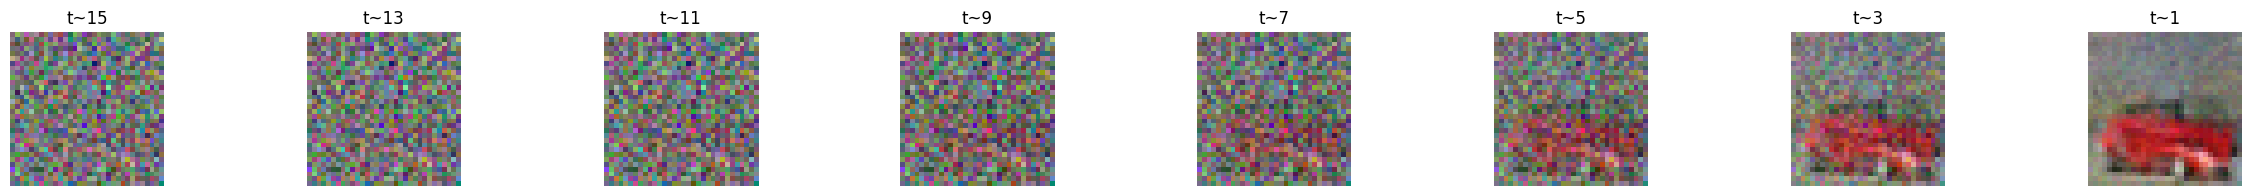


Final generated images from this run:


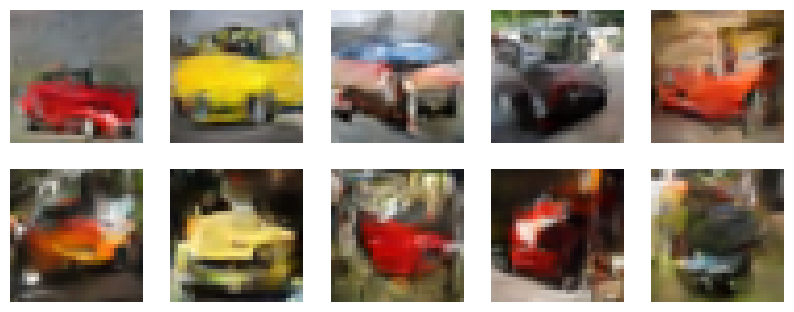


--- Starting Master Round 9/10 ---


loss: 0.02033: 100%|██████████| 50/50 [07:37<00:00,  9.14s/it]



Learning rate updated to: 0.000310
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 19.78it/s]



Final Generated Images:


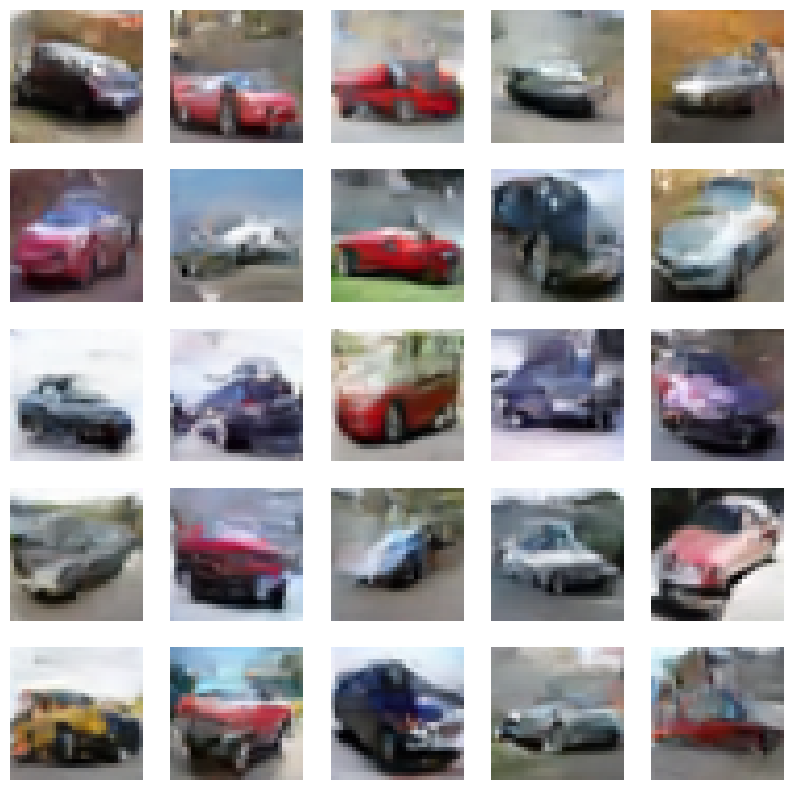

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.66it/s]



Denoising sequence (from t=15 down to t=0):


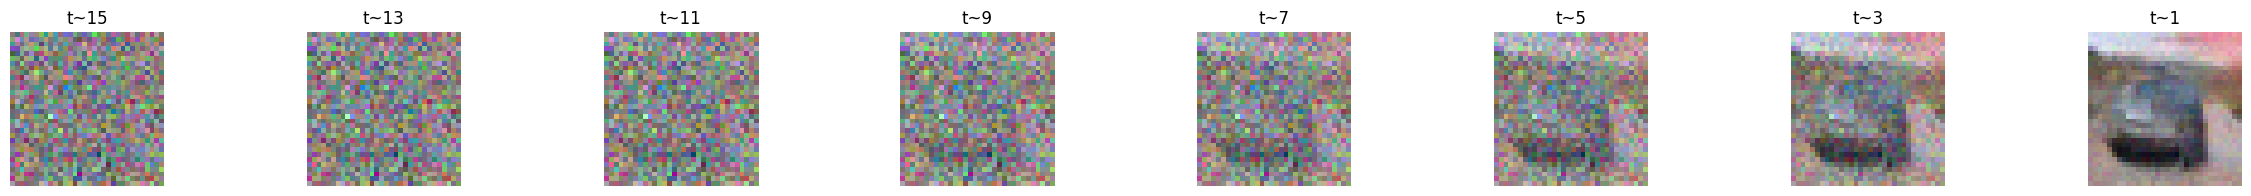


Final generated images from this run:


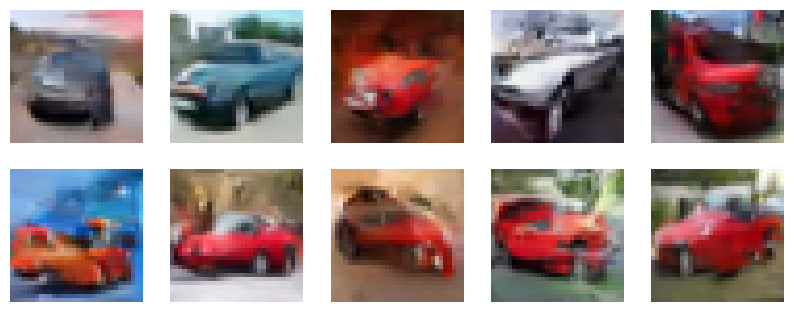


--- Starting Master Round 10/10 ---


loss: 0.02079: 100%|██████████| 50/50 [07:33<00:00,  9.07s/it]



Learning rate updated to: 0.000279
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.83it/s]



Final Generated Images:


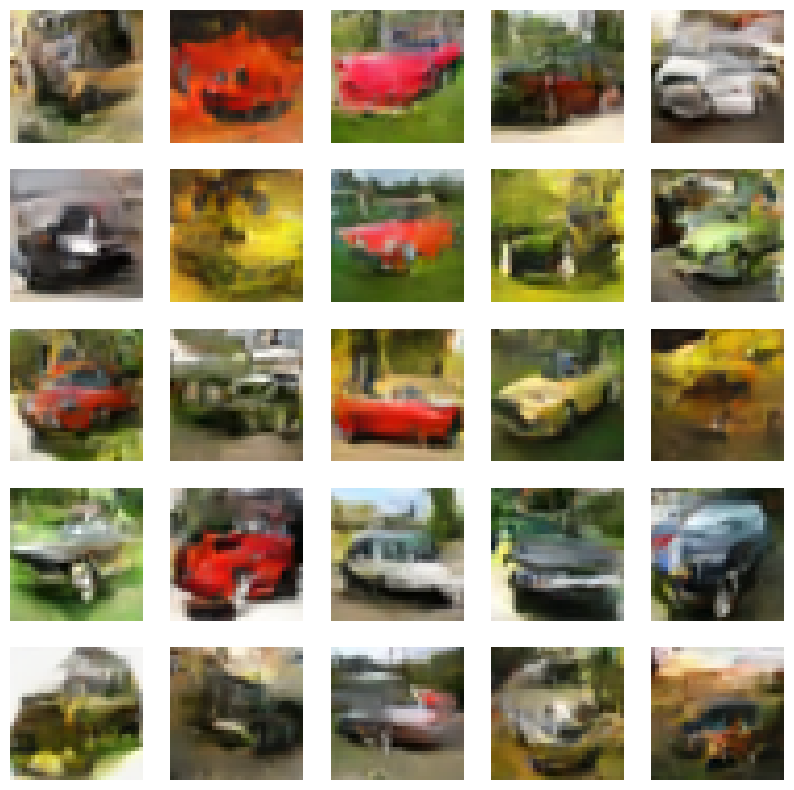

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 18.43it/s]



Denoising sequence (from t=15 down to t=0):


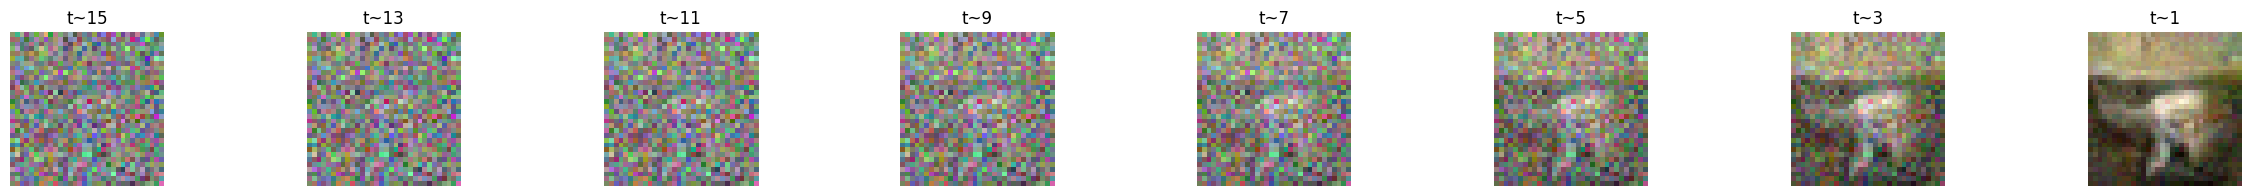


Final generated images from this run:


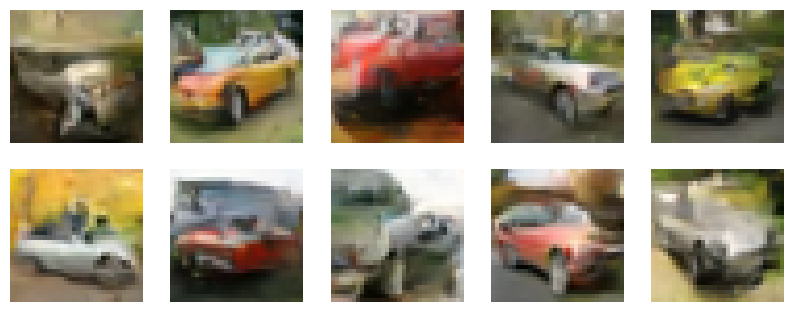


--- Starting Master Round 11/10 ---


loss: 0.02034: 100%|██████████| 50/50 [07:39<00:00,  9.19s/it]



Learning rate updated to: 0.000251
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.35it/s]



Final Generated Images:


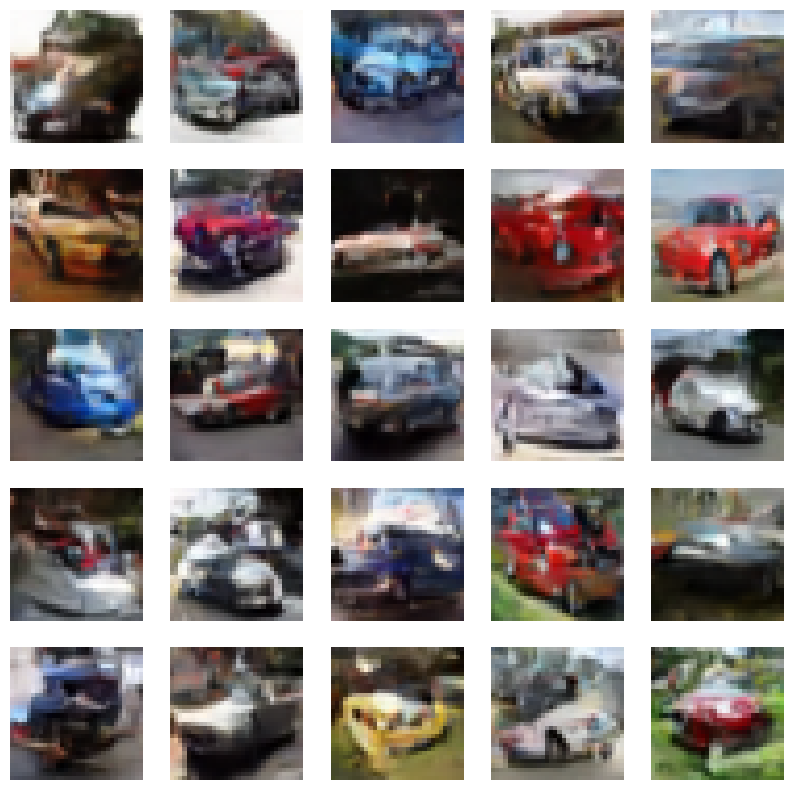

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.23it/s]



Denoising sequence (from t=15 down to t=0):


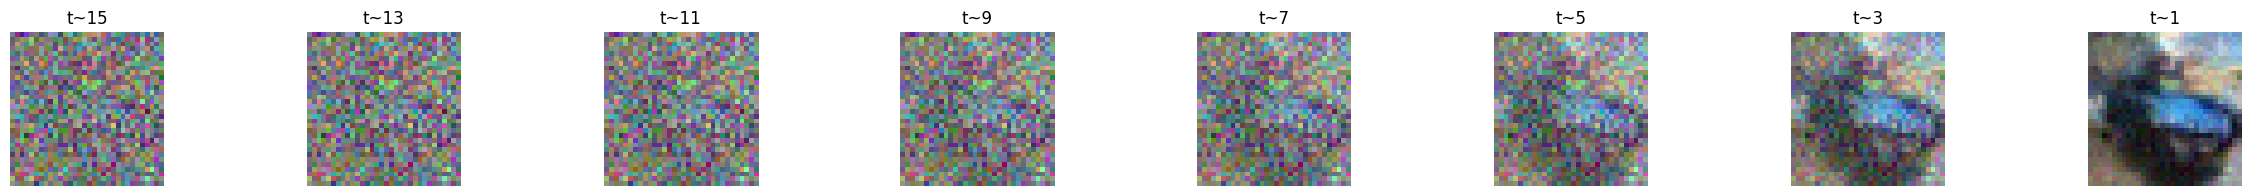


Final generated images from this run:


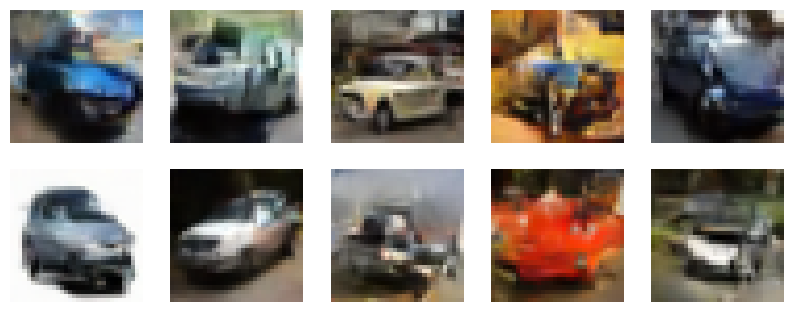


--- Starting Master Round 12/10 ---


loss: 0.01980: 100%|██████████| 50/50 [07:39<00:00,  9.20s/it]



Learning rate updated to: 0.000226
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 19.44it/s]



Final Generated Images:


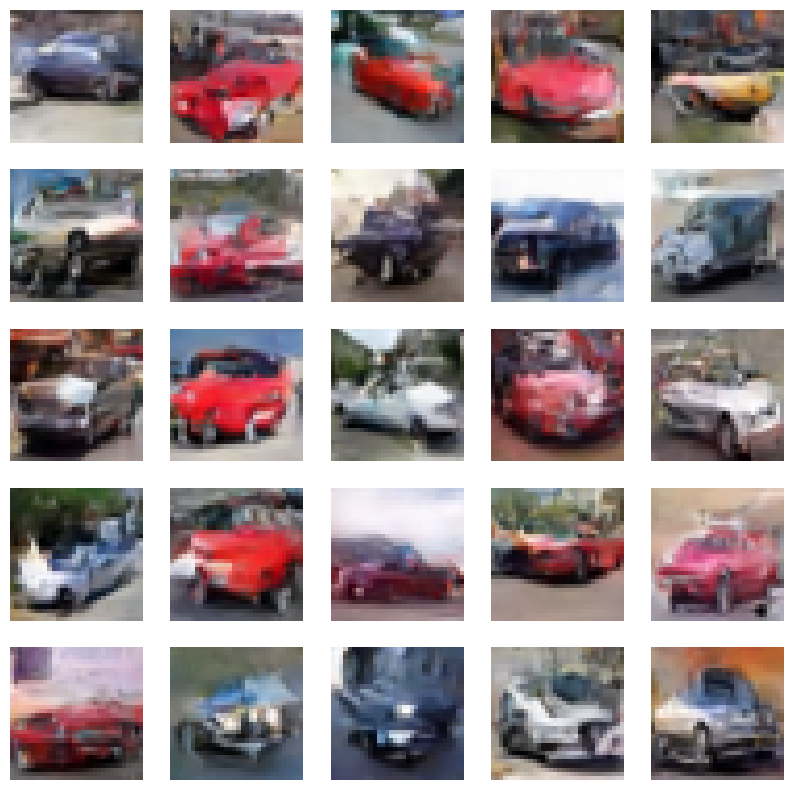

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.10it/s]



Denoising sequence (from t=15 down to t=0):


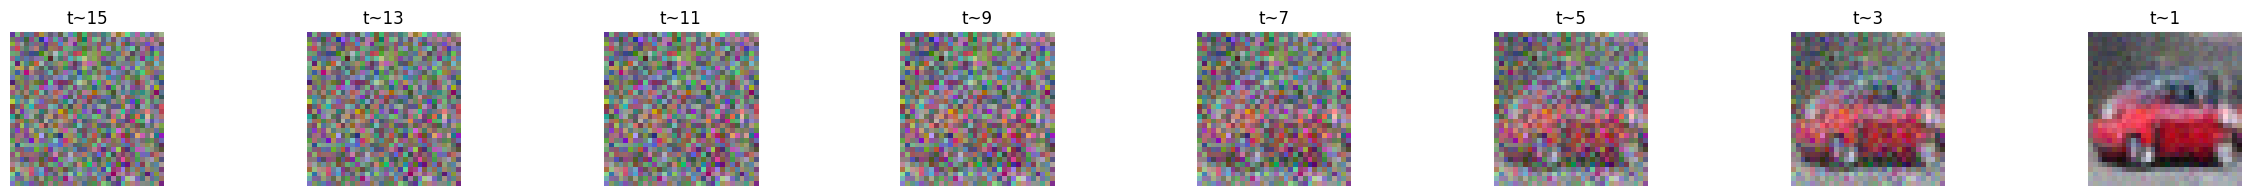


Final generated images from this run:


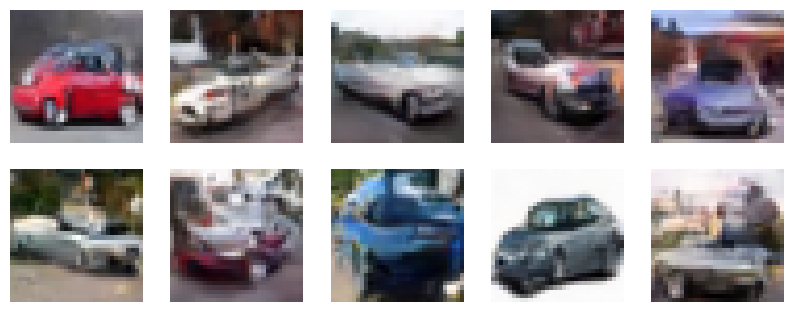


--- Starting Master Round 13/10 ---


loss: 0.02045: 100%|██████████| 50/50 [07:33<00:00,  9.07s/it]



Learning rate updated to: 0.000203
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.64it/s]



Final Generated Images:


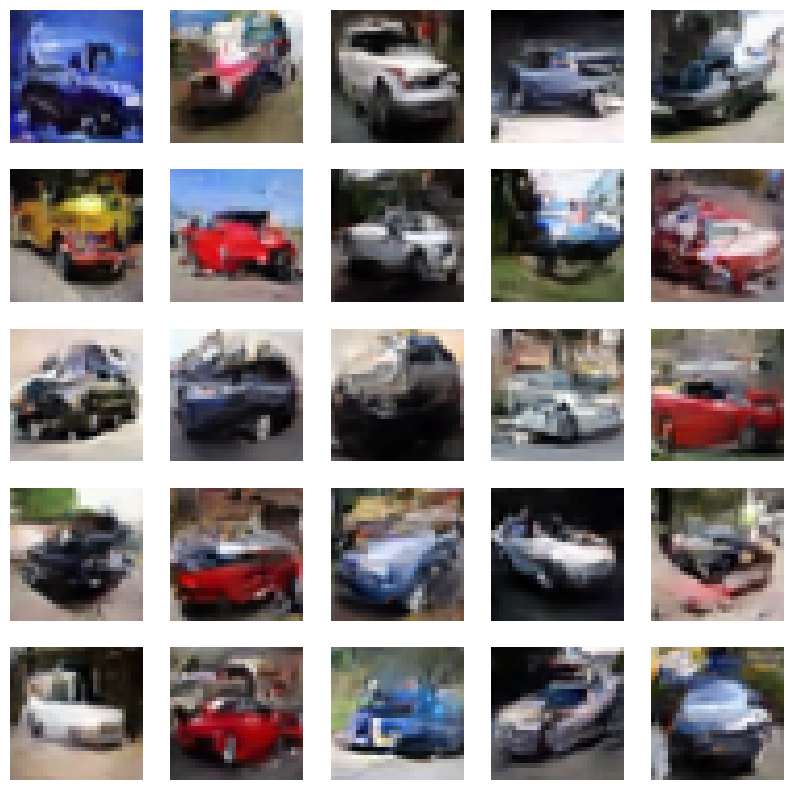

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 18.88it/s]



Denoising sequence (from t=15 down to t=0):


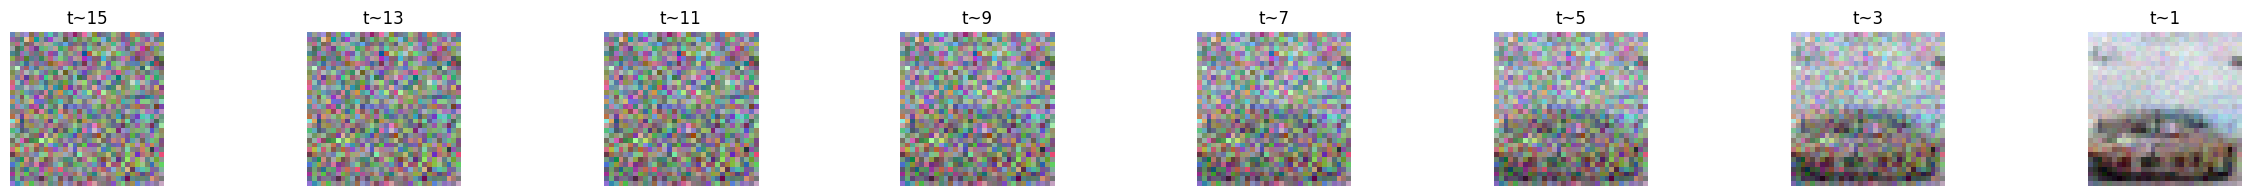


Final generated images from this run:


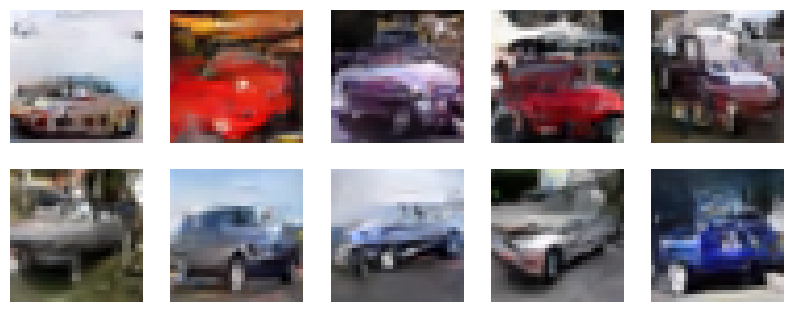


--- Starting Master Round 14/10 ---


loss: 0.01946: 100%|██████████| 50/50 [07:30<00:00,  9.00s/it]



Learning rate updated to: 0.000183
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 19.90it/s]



Final Generated Images:


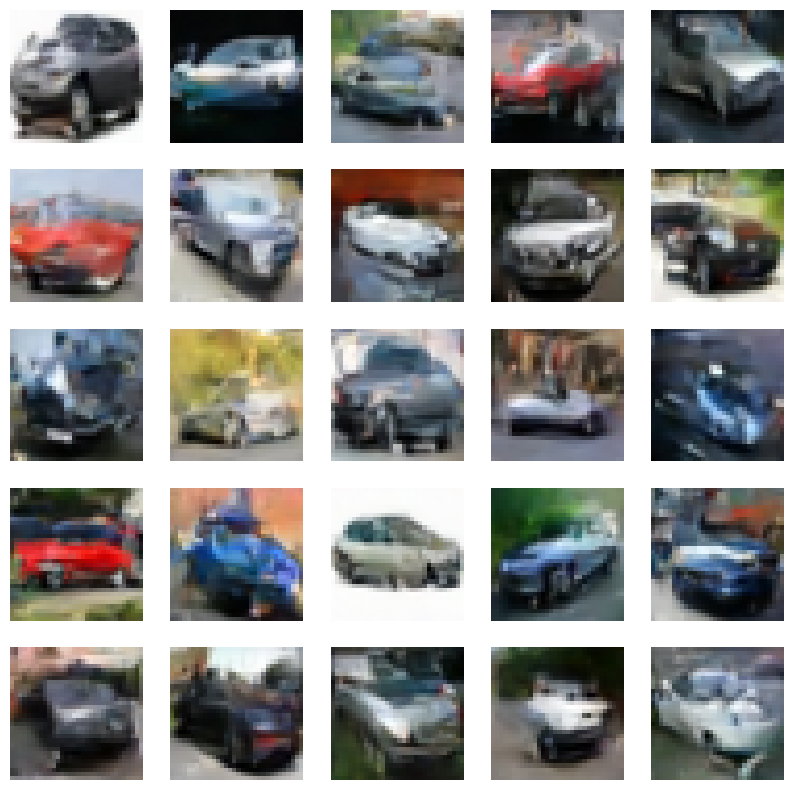

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.52it/s]



Denoising sequence (from t=15 down to t=0):


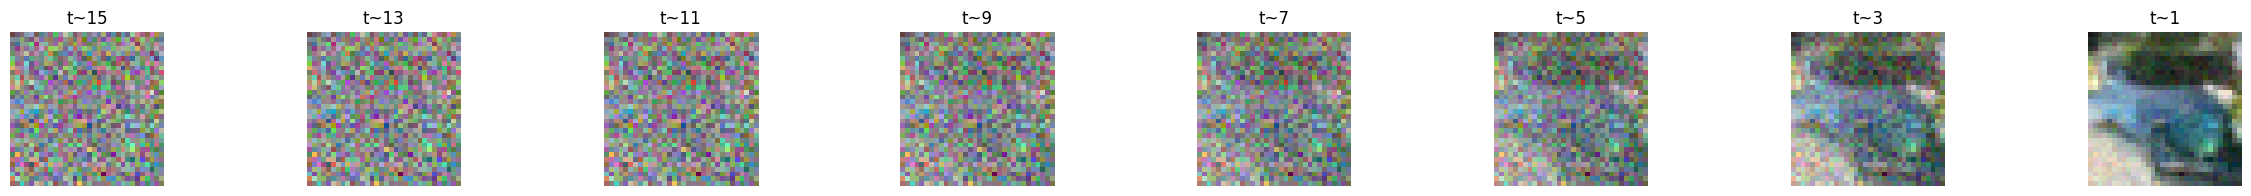


Final generated images from this run:


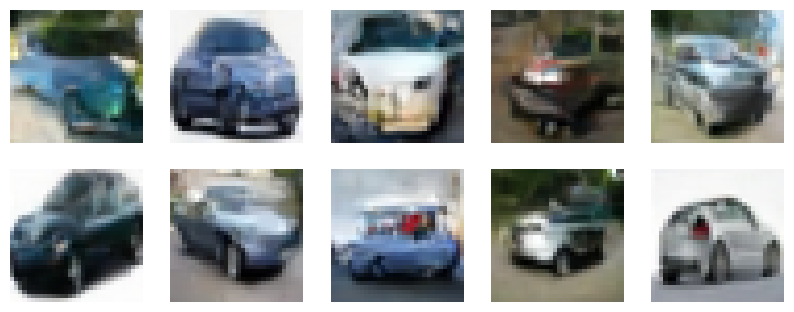


--- Starting Master Round 15/10 ---


loss: 0.01992: 100%|██████████| 50/50 [07:32<00:00,  9.06s/it]



Learning rate updated to: 0.000165
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 19.37it/s]



Final Generated Images:


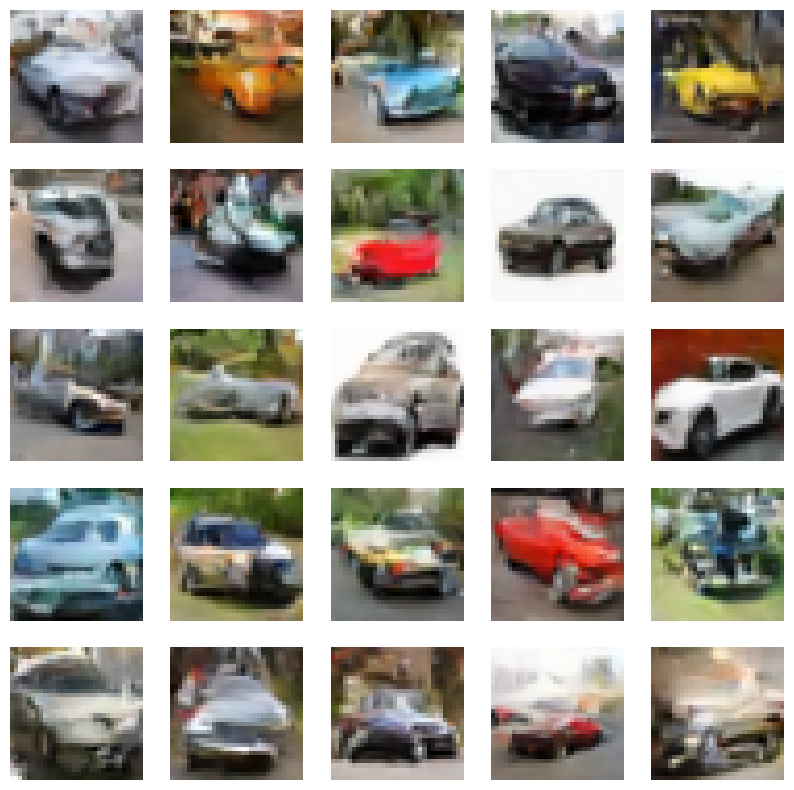

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 18.71it/s]



Denoising sequence (from t=15 down to t=0):


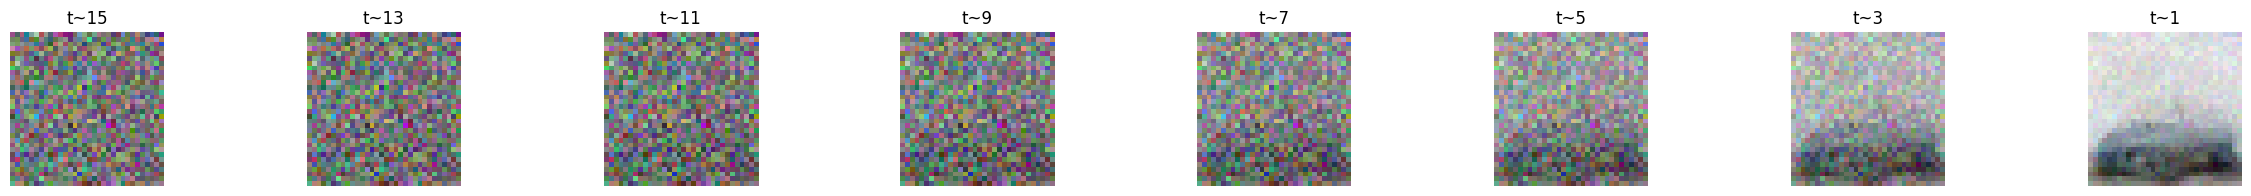


Final generated images from this run:


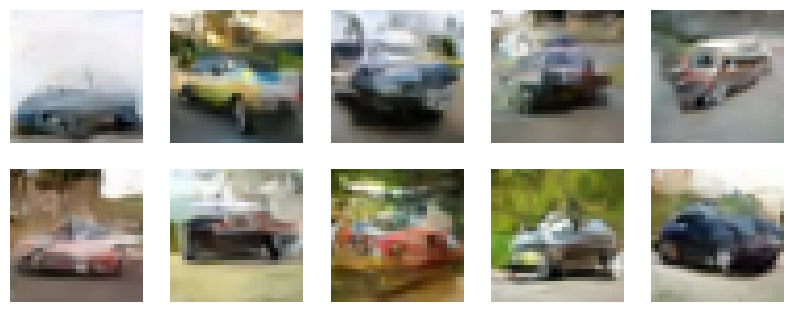


--- Starting Master Round 16/10 ---


loss: 0.01929: 100%|██████████| 50/50 [07:30<00:00,  9.01s/it]



Learning rate updated to: 0.000148
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.87it/s]



Final Generated Images:


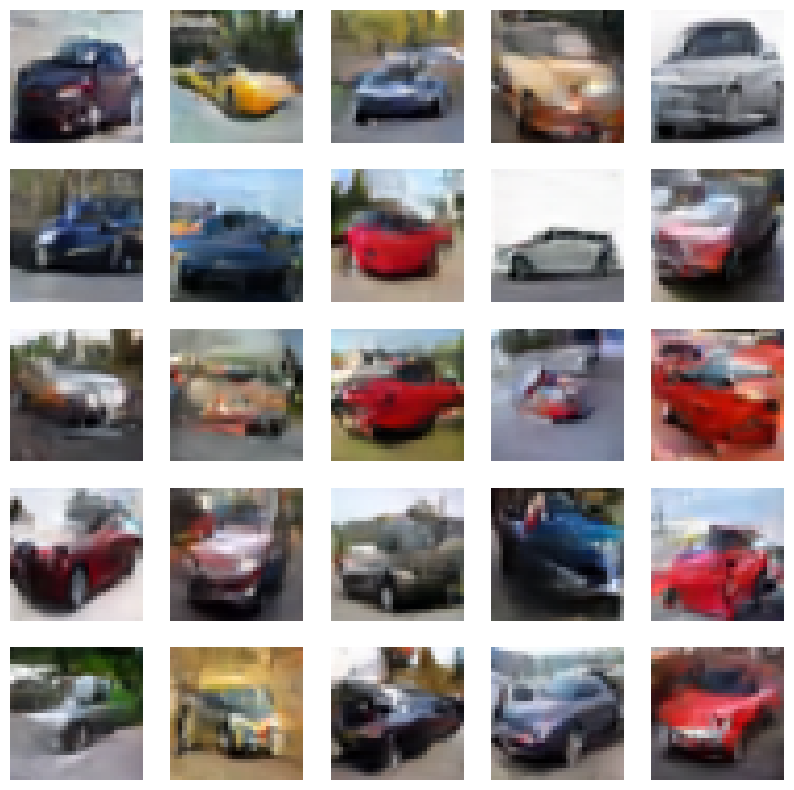

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 18.61it/s]



Denoising sequence (from t=15 down to t=0):


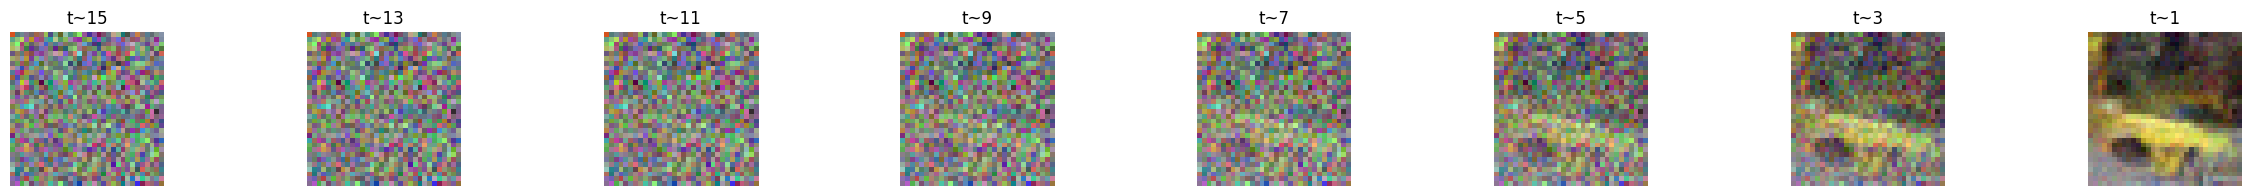


Final generated images from this run:


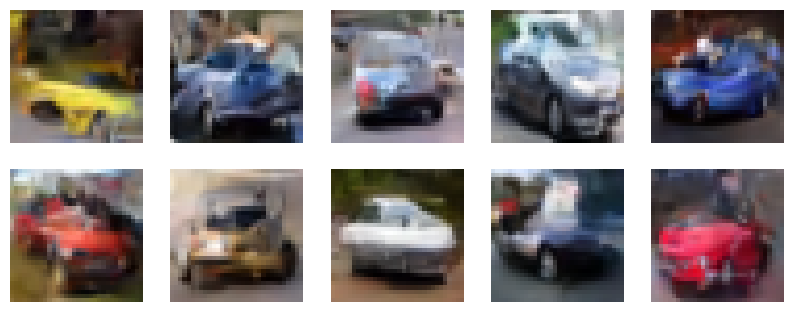


--- Starting Master Round 17/10 ---


loss: 0.01996: 100%|██████████| 50/50 [07:19<00:00,  8.79s/it]



Learning rate updated to: 0.000133
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.31it/s]



Final Generated Images:


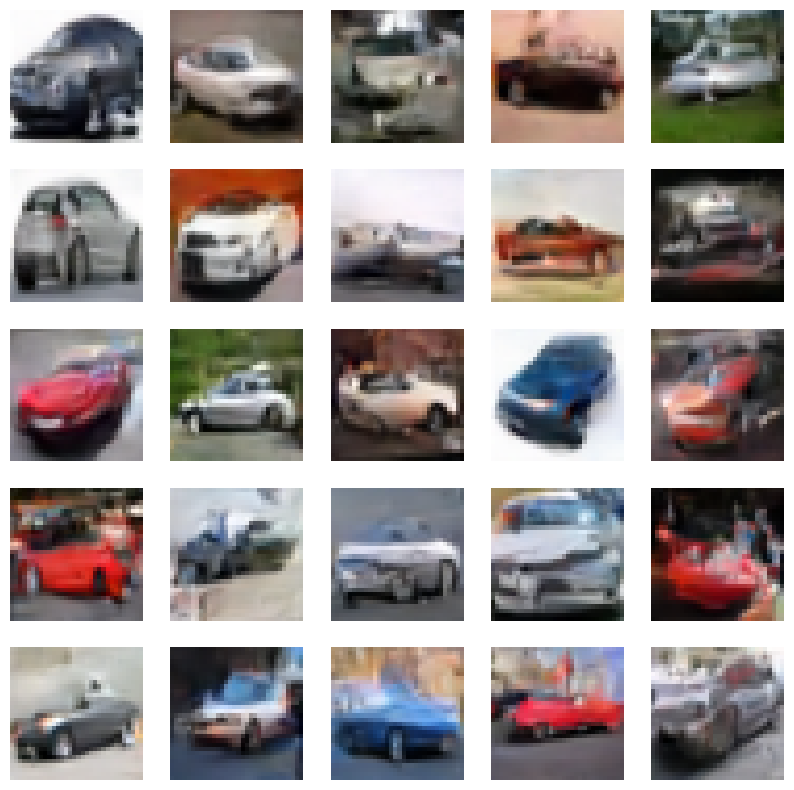

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 20.06it/s]



Denoising sequence (from t=15 down to t=0):


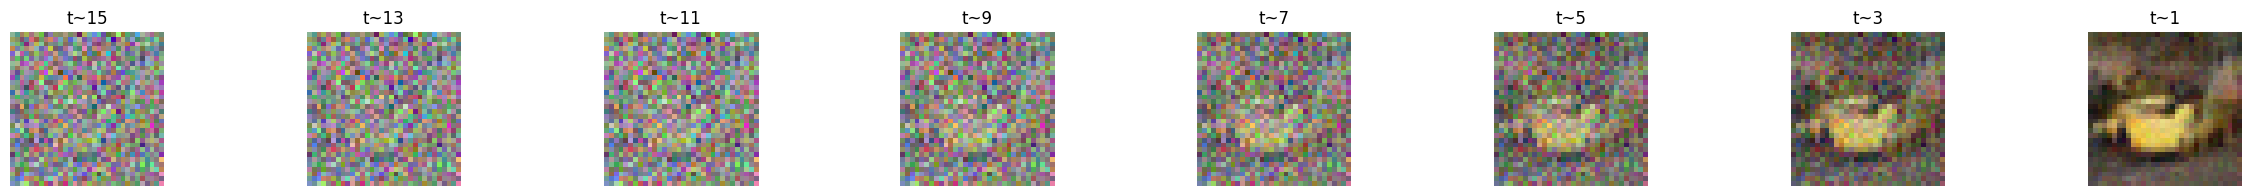


Final generated images from this run:


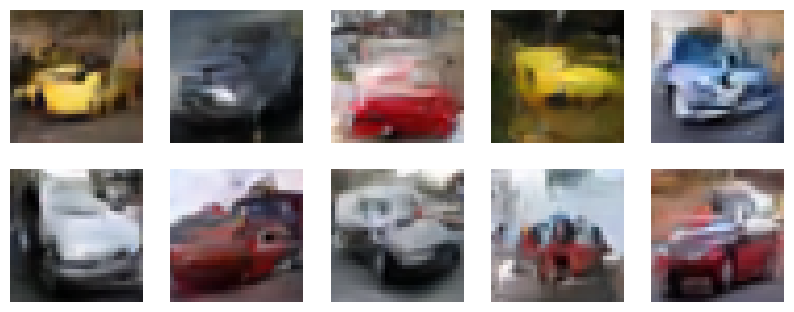


--- Starting Master Round 18/10 ---


loss: 0.02005: 100%|██████████| 50/50 [07:09<00:00,  8.58s/it]



Learning rate updated to: 0.000120
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 19.37it/s]



Final Generated Images:


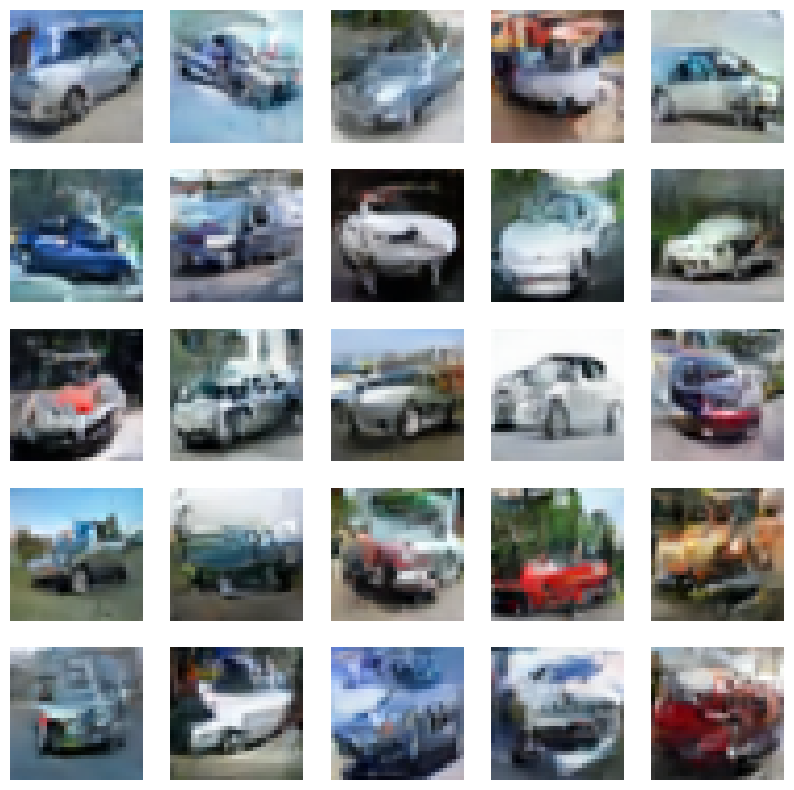

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.30it/s]



Denoising sequence (from t=15 down to t=0):


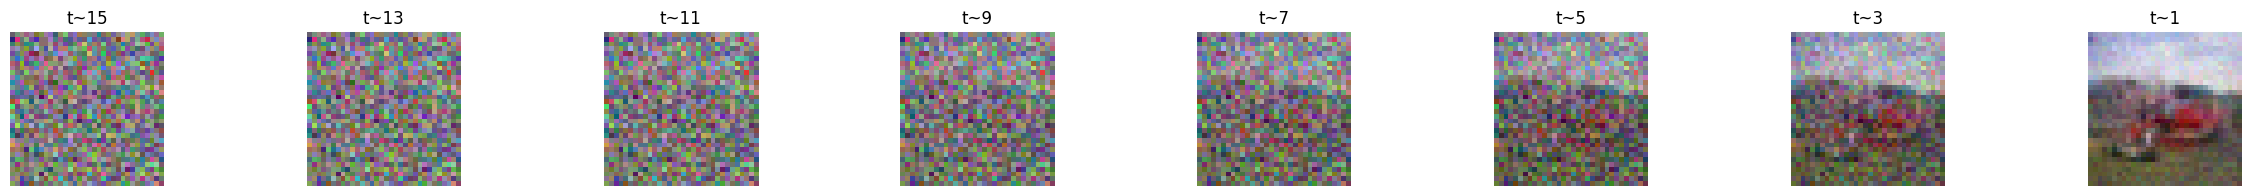


Final generated images from this run:


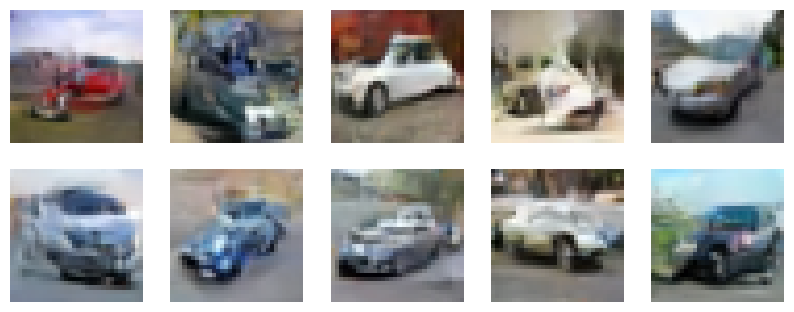


--- Starting Master Round 19/10 ---


loss: 0.02062: 100%|██████████| 50/50 [07:05<00:00,  8.51s/it]



Learning rate updated to: 0.000108
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.14it/s]



Final Generated Images:


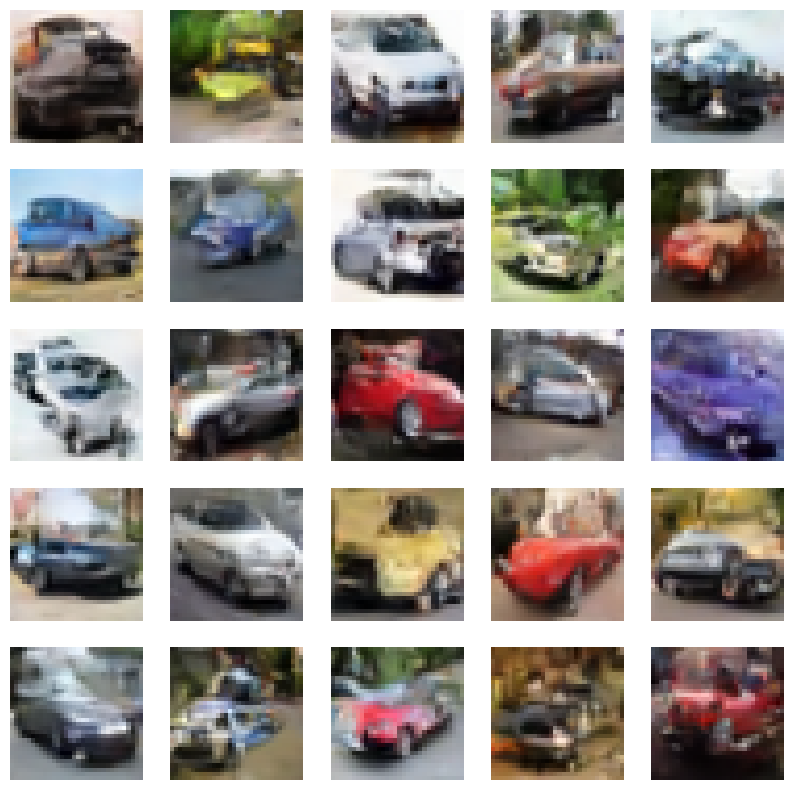

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 18.76it/s]



Denoising sequence (from t=15 down to t=0):


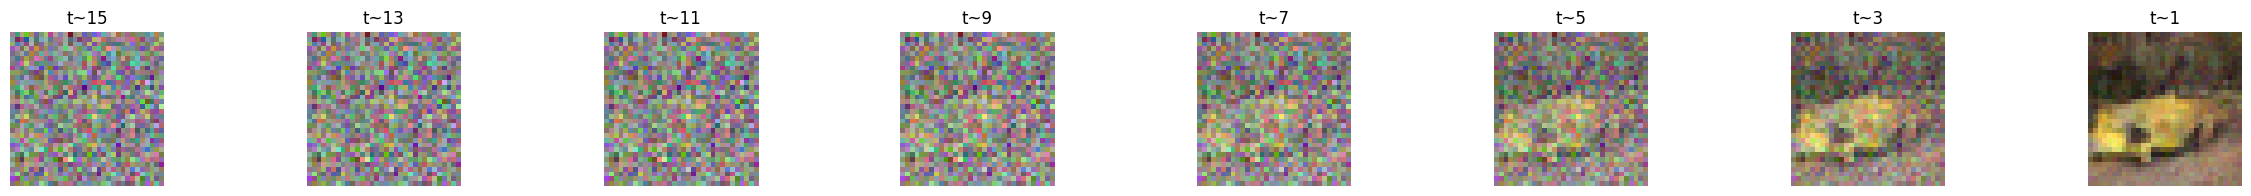


Final generated images from this run:


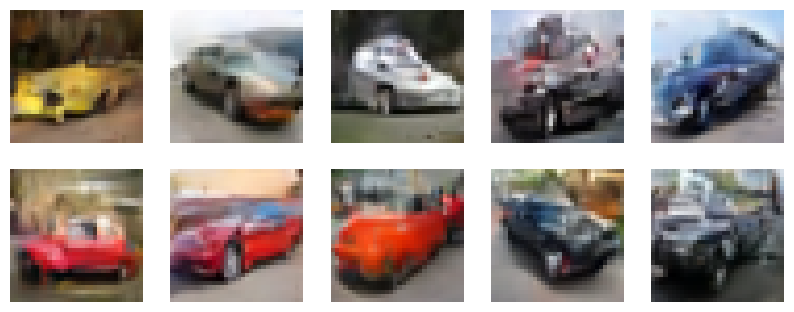


--- Starting Master Round 20/10 ---


loss: 0.01973: 100%|██████████| 50/50 [07:07<00:00,  8.56s/it]



Learning rate updated to: 0.000097
Generating sample images...


100%|██████████| 16/16 [00:00<00:00, 20.39it/s]



Final Generated Images:


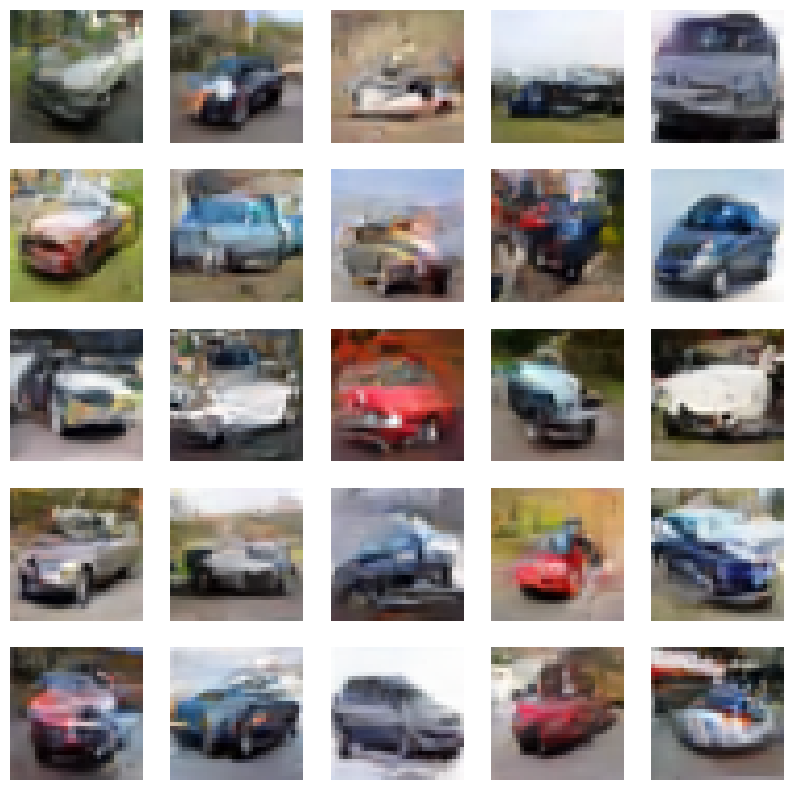

Visualizing denoising steps...
Visualizing the reverse diffusion process...


100%|██████████| 16/16 [00:00<00:00, 19.78it/s]



Denoising sequence (from t=15 down to t=0):


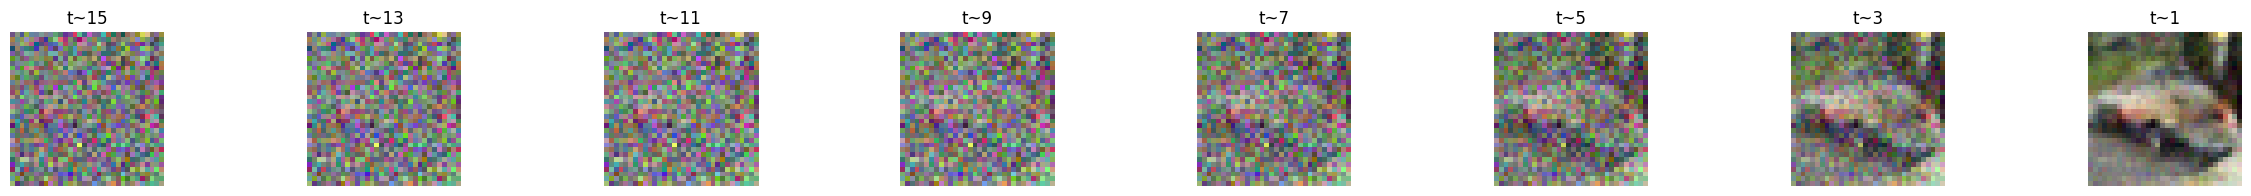


Final generated images from this run:


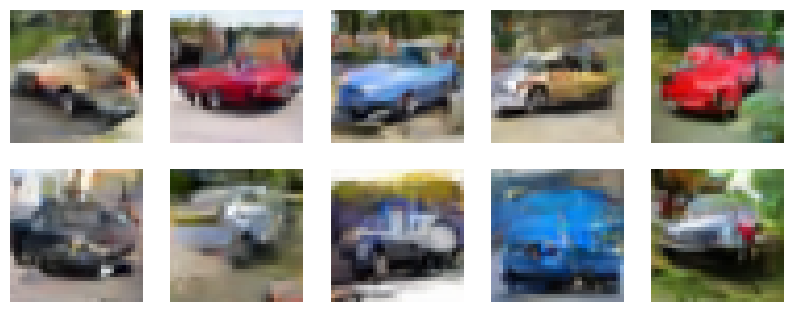


--- COMPLETE TRAINING FINISHED ---


In [ ]:
# This main loop will run the entire training process 10 times.
# Each iteration represents a full training session followed by evaluation.
for i in range(20):
    print(f"\n--- Starting Master Round {i+1}/10 ---")

    # 1. Perform a full training session (50 epochs by default).
    train()

    # 2. Implement learning rate decay.
    # We reduce the learning rate by 10% after each full session.
    # This helps the model to fine-tune its parameters and avoid overshooting
    # the optimal solution as it gets closer to converging.
    # We set a minimum floor of 0.000001 to prevent the learning rate from becoming too small.
    new_lr = max(0.000001, model.optimizer.learning_rate * 0.9)
    model.optimizer.learning_rate.assign(new_lr)
    print(f"\nLearning rate updated to: {model.optimizer.learning_rate.numpy():.6f}")

    # 3. Visualize the results after this training round.
    # This allows us to track improvement over time.

    # Generate a grid of final images from random noise.
    print("Generating sample images...")
    predict()

    # Show the step-by-step denoising process with the updated model.
    print("Visualizing denoising steps...")
    predict_step()

    # Ensure all matplotlib plots are displayed before the next round.
    plt.show()

print("\n--- COMPLETE TRAINING FINISHED ---")